### NASA-TLX model

In [58]:
import pandas as pd
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
import jax.numpy as jnp
import jax.random as random
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import jax

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set_theme(style='whitegrid')

In [ ]:
root = './'
path = root + '/img/cog/'

### Some data cleaning

In [61]:
nasatlx = pd.read_csv(root + '/data/nasatlx.csv')

# Define the column names explicitly
nasatlx.columns = [
    'user_id', 'Version', 'Ratings',  # Participant info
    'Mental', 'Physical', 'Temporal', 'Performance', 'Effort', 'Frustration',  # Raw scores
    'Ranking',  # Possibly unused
    'Mental_Count', 'Physical_Count', 'Temporal_Count', 'Performance_Count', 'Effort_Count', 'Frustration_Count',  # Weights (pairwise comparisons)
    'Total_Count', 'Adjusted_Rating',  # Total counts and adjusted rating (possibly unused)
    'Mental_Weighted', 'Physical_Weighted', 'Temporal_Weighted', 'Performance_Weighted', 'Effort_Weighted', 'Frustration_Weighted',  # Weighted scores
    'Sum_Weighted', 'Weighted_Rate'  # Sum and total weighted rate
]

# Correct typo in column names
nasatlx.rename(columns={'Fustration_Count': 'Frustration_Count', 'Fustration_Weighted': 'Frustration_Weighted'}, inplace=True)
# List of columns to convert to numeric
numeric_cols = [
    'Mental', 'Physical', 'Temporal', 'Performance', 'Effort', 'Frustration',
    'Mental_Count', 'Physical_Count', 'Temporal_Count', 'Performance_Count', 'Effort_Count', 'Frustration_Count',
    'Mental_Weighted', 'Physical_Weighted', 'Temporal_Weighted', 'Performance_Weighted', 'Effort_Weighted', 'Frustration_Weighted',
    'Sum_Weighted', 'Weighted_Rate', 'Total_Count'
]

# Convert columns to numeric, handling errors
for col in numeric_cols:
    nasatlx[col] = pd.to_numeric(nasatlx[col], errors='coerce')

# Map Versions to Conditions
version_mapping = {
    'v1': {'Options': 'Short', 'Interface': 'Static'},
    'v2': {'Options': 'Short', 'Interface': 'Interactive'},
    'v3': {'Options': 'Long', 'Interface': 'Static'},
    'v4': {'Options': 'Long', 'Interface': 'Interactive'}
}

nasatlx['Options'] = nasatlx['Version'].map(lambda x: version_mapping[x]['Options'])
nasatlx['Interface'] = nasatlx['Version'].map(lambda x: version_mapping[x]['Interface'])

# Encode categorical variables
nasatlx['Options_Encoded'] = nasatlx['Options'].map({'Short': 0, 'Long': 1})
nasatlx['Interface_Encoded'] = nasatlx['Interface'].map({'Static': 0, 'Interactive': 1})

# Create interaction term
nasatlx['Interaction'] = nasatlx['Options_Encoded'] * nasatlx['Interface_Encoded']

In [62]:
#user_id	Version	Ratings	Mental	Physical	Temporal	Performance	Effort	Frustration	Ranking	...	Performance_Weighted	Effort_Weighted	Frustration_Weighted	Sum_Weighted	Weighted_Rate	Options	Interface	Options_Encoded	Interface_Encoded	Interaction
# give me user_id, and mental, physical, temporal, performance, effort, frustration
nasatlx_exp = nasatlx[['user_id', 'Version', 'Mental', 'Physical', 'Temporal', 'Performance', 'Effort', 'Frustration', 'Options_Encoded', 'Interface_Encoded']]
# rename columns
col_name_mapping = {
    'user_id': 'user_id',
    'Version': 'version',
    'Mental': 'mental',
    'Physical': 'physical',
    'Temporal': 'temporal',
    'Performance': 'performance',
    'Effort': 'effort',
    'Frustration': 'frustration',
    'Options_Encoded': 'option_group',
    'Interface_Encoded': 'interface_group'
}
nasatlx_exp.rename(columns=col_name_mapping, inplace=True)
nasatlx_exp.head()

/tmp/ipykernel_6197/2372871379.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nasatlx_exp.rename(columns=col_name_mapping, inplace=True)


,user_id,version,mental,physical,temporal,performance,effort,frustration,option_group,interface_group
0,S001,v3,25,0,5,0,5,20,1,0
1,S002,v2,80,5,15,30,65,40,0,1
2,S003,v1,70,5,10,55,65,60,0,0
3,S004,v4,35,5,25,20,5,15,1,1
4,S005,v3,100,0,0,10,100,75,1,0


In [63]:
from sklearn.preprocessing import LabelEncoder

df = nasatlx_exp.copy()
user_encoder = LabelEncoder()
df["user_idx"] = user_encoder.fit_transform(df["user_id"])

# Interface index (binary: 0 = static, 1 = interactive)
interface_idx = df["interface_group"].values

# Length index (binary: 0 = short, 1 = long)
length_idx = df["option_group"].values

# User index
user_idx = df["user_idx"].values

# Subscale scores (matrix of shape [n_samples, n_subscales])
tlx_scores = df[["mental", "physical", "temporal", "performance", "effort", "frustration"]].values

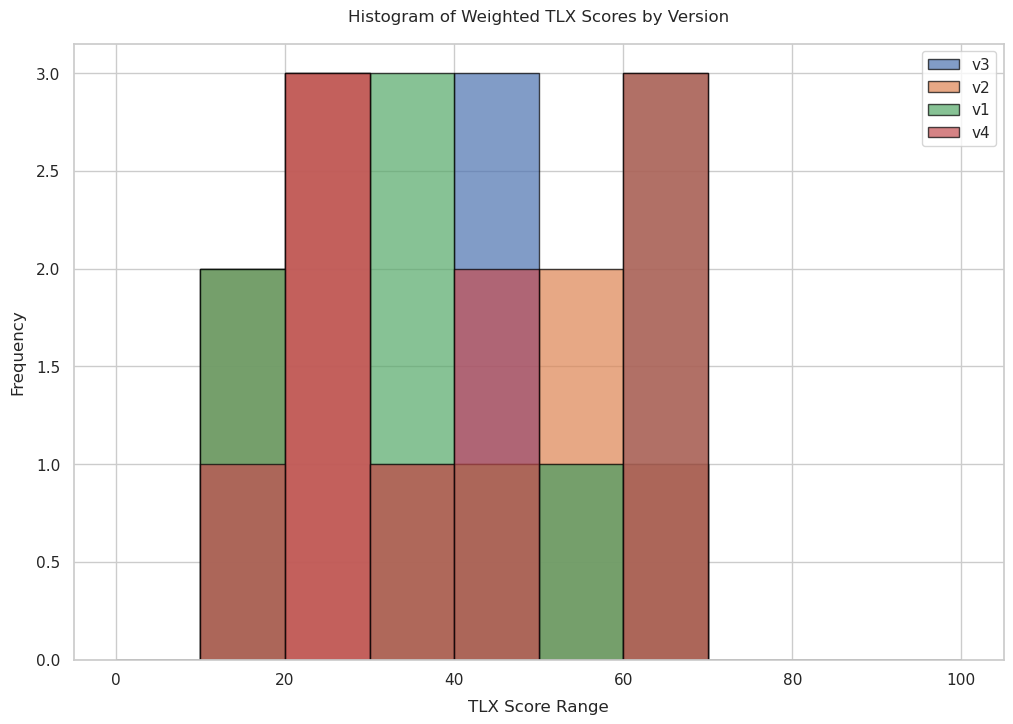

In [64]:
nasatlx['Weighted_Rate']
# bin by 10s and draw histogram for each version
plt.figure(figsize=(12, 8))
for version in nasatlx['Version'].unique():
    subset = nasatlx[nasatlx['Version'] == version]
    plt.hist(subset['Weighted_Rate'], bins=np.arange(0, 101, 10), alpha=0.7, label=version, edgecolor='black')
plt.title("Histogram of Weighted TLX Scores by Version")
plt.xlabel("TLX Score Range")
plt.ylabel("Frequency")
plt.legend()

### binning ordinal
Since there are no level 3 and 4s, we model the first three

In [65]:
# Redefine the bins and labels
bins = [0, 30, 50, 80]
labels = [0, 1, 2]  # Labels will be 0, 1, 2

# Re-bin the Weighted_Rate scores
nasatlx['Ordinal_Score'] = pd.cut(
    nasatlx['Weighted_Rate'],
    bins=bins,
    labels=labels,
    include_lowest=True,
    right=False
).astype(int)

# Extract the ordinal data
ordinal_data = nasatlx['Ordinal_Score'].values
ordinal_data = jnp.array(ordinal_data)


In [66]:
ordinal_data

Array([0, 2, 2, 0, 2, 0, 1, 0, 1, 0, 1, 2, 1, 2, 0, 2, 1, 2, 1, 2, 0, 0,
       2, 0, 2, 1, 0, 2, 0, 1, 0, 1, 1, 1, 2, 0, 0, 1, 0, 0], dtype=int32)

In [67]:
# Count the occurrences of each category
category_counts = np.bincount(ordinal_data)
print(f"Category Counts: {category_counts}")


Category Counts: [16 12 12]


In [68]:
from numpyro.distributions.transforms import OrderedTransform

In [69]:
def ordinal_regression_model(length_encoded, interface_encoded, num_categories, ordinal_data=None):
    # Hyperpriors for Length coefficients (ordinal)
    mu_length = numpyro.sample('mu_length', dist.Normal(0, 1))  # Intercept
    beta_length = numpyro.sample('beta_length', dist.Normal(0, 1))  # Slope

    # Compute length effect as ordinal
    length_effect = mu_length + beta_length * length_encoded

    # --- Hyperpriors for Interface Coefficients (Unchanged) ---
    mu_interface = numpyro.sample('mu_interface', dist.Normal(0, 1))
    sigma_interface = numpyro.sample('sigma_interface', dist.Exponential(1))
    beta_interface_raw = numpyro.sample('beta_interface_raw', dist.Normal(0, 1).expand([2]))
    beta_interface = numpyro.deterministic('beta_interface', mu_interface + beta_interface_raw * sigma_interface)

    # --- Interaction Effect (Unchanged) ---
    num_length_levels = 2
    num_interface_levels = 2

    # Standard deviations for interaction terms
    sigma_interaction = numpyro.sample('sigma_interaction', dist.Exponential(1).expand([num_length_levels, num_interface_levels]))

    # LKJ prior on the correlation matrix
    L_Omega = numpyro.sample('L_Omega', dist.LKJCholesky(num_length_levels, 2))

    # Adaptive priors (non-centered)
    z_interaction = numpyro.sample('z_interaction', dist.Normal(0, 1).expand([num_length_levels, num_interface_levels]))

    # Compute interaction coefficients
    beta_interaction = jnp.einsum('ij,jk->ik', L_Omega, sigma_interaction * z_interaction)

    # Prior for intercept
    alpha = numpyro.sample('alpha', dist.Normal(0, 1))
    # Linear predictor with corrected interaction coefficients
    eta = (
        alpha +
        length_effect +
        beta_interface[interface_encoded] +
        beta_interaction[length_encoded, interface_encoded]
    )
    numpyro.deterministic("eta", eta)

    # Thresholds (cutpoints), ensure they are ordered
    cutpoints = numpyro.sample('cutpoints', dist.TransformedDistribution(
        dist.Normal(0, 1).expand([num_categories - 1]),
        dist.transforms.OrderedTransform()
    ))

    # Likelihood
    numpyro.sample('obs', dist.OrderedLogistic(eta, cutpoints), obs=ordinal_data)

In [70]:
length_encoded = jnp.array(nasatlx['Options_Encoded'].values)
interface_encoded = jnp.array(nasatlx['Interface_Encoded'].values)
display(length_encoded)
display(interface_encoded)

Array([1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1], dtype=int32)

Array([0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0], dtype=int32)

In [71]:
num_categories = 3

# Set up the NUTS kernel
nuts_kernel = NUTS(ordinal_regression_model, target_accept_prob=0.9)

# Set up the MCMC sampler
mcmc = MCMC(nuts_kernel, num_warmup=5000, num_samples=2000, num_chains=2)

# Run the MCMC sampling
mcmc.run(
    jax.random.PRNGKey(0),
    length_encoded=length_encoded,
    interface_encoded=interface_encoded,
    ordinal_data=ordinal_data,
    num_categories=num_categories
)

mcmc.print_summary()


/tmp/ipykernel_6197/274889469.py:7: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts_kernel, num_warmup=5000, num_samples=2000, num_chains=2)
sample: 100%|██████████| 7000/7000 [00:02<00:00, 2618.53it/s, 31 steps of size 1.40e-01. acc. prob=0.91]


                            mean       std    median      5.0%     95.0%     n_eff     r_hat
          L_Omega[0,0]      1.00      0.00      1.00      1.00      1.00       nan       nan
          L_Omega[0,1]      0.00      0.00      0.00      0.00      0.00       nan       nan
          L_Omega[1,0]      0.01      0.46      0.02     -0.70      0.78   4136.54      1.00
          L_Omega[1,1]      0.88      0.14      0.93      0.67      1.00   1766.28      1.00
                 alpha      0.11      0.90      0.13     -1.39      1.58   3660.40      1.00
 beta_interface_raw[0]      0.06      0.88      0.07     -1.42      1.46   3453.03      1.00
 beta_interface_raw[1]     -0.04      0.87     -0.05     -1.42      1.43   3604.78      1.00
           beta_length     -0.22      0.66     -0.23     -1.24      0.92   3883.34      1.00
          cutpoints[0]     -0.14      0.88     -0.15     -1.63      1.24   3601.09      1.00
          cutpoints[1]      1.13      0.93      1.12     -0.33      2

In [72]:
posterior_samples = mcmc.get_samples()

# Set up the predictive distribution
predictive = Predictive(ordinal_regression_model, posterior_samples)

# Generate posterior predictive samples
post_pred_samples = predictive(
    jax.random.PRNGKey(1),
    length_encoded=length_encoded,
    interface_encoded=interface_encoded,
    ordinal_data=None,  # Use None to generate predictions
    num_categories=num_categories
)

# Extract predictive samples for 'obs'
pred_obs = post_pred_samples["obs"]  # Shape: (num_samples, num_observations)


In [73]:
# Define labels for the versions
interaction_labels = ["Short-Static", "Short-Interactive", "Long-Static", "Long-Interactive"]

# Recreate interaction_encoded
interaction_encoded = length_encoded * 2 + interface_encoded  # Generates indices 0 to 3

# Organize observed data by version
observed_data_by_version = {
    interaction_labels[i]: ordinal_data[interaction_encoded == i]
    for i in range(4)
}

# Organize predicted data by version
predicted_data_by_version = {
    interaction_labels[i]: pred_obs[:, interaction_encoded == i]
    for i in range(4)
}


In [74]:
# Function to compute category counts
def compute_category_counts(data, num_categories):
    counts = np.array([np.bincount(sample, minlength=num_categories) for sample in data])
    return counts  # Shape: (num_samples, num_categories)

# Compute observed category counts
observed_counts_by_version = {
    label: np.bincount(data, minlength=num_categories)
    for label, data in observed_data_by_version.items()
}

# Compute predicted category counts (mean over samples)
predicted_counts_by_version = {
    label: compute_category_counts(samples, num_categories).mean(axis=0)
    for label, samples in predicted_data_by_version.items()
}


In [75]:
c1 = color_exp = sns.diverging_palette(240, 10, n=9)[1]
c2 = color_exp = sns.diverging_palette(240, 10, n=9)[7]
sns.color_palette([c1, c2])

[(0.42852192568663816, 0.6022859457022, 0.7307907632583843),
 (0.8778561044506711, 0.4033908325269278, 0.43869244817003017)]

### Posterior test

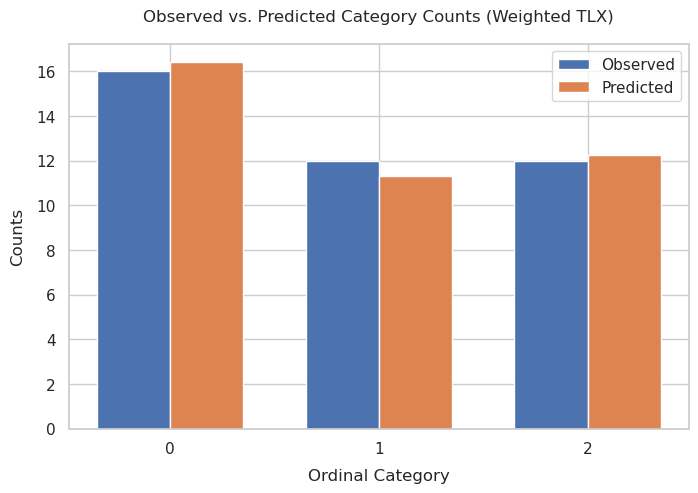

In [76]:
# Aggregate observed and predicted counts across all versions
total_observed_counts = sum(observed_counts_by_version.values())
total_predicted_counts = sum(predicted_counts_by_version.values())

categories = np.arange(len(total_observed_counts))  # Ensure the number of categories matches the data
width = 0.35  # Width of the bars

# Plot combined observed vs predicted counts
plt.figure(figsize=(8, 5))
plt.bar(categories - width/2, total_observed_counts, width, label='Observed')
plt.bar(categories + width/2, total_predicted_counts, width, label='Predicted')
plt.xlabel('Ordinal Category')
plt.ylabel('Counts')
plt.title('Observed vs. Predicted Category Counts (Weighted TLX)')
plt.xticks(categories)
plt.legend()
plt.savefig('observed_vs_predicted_combined.png')
plt.show()


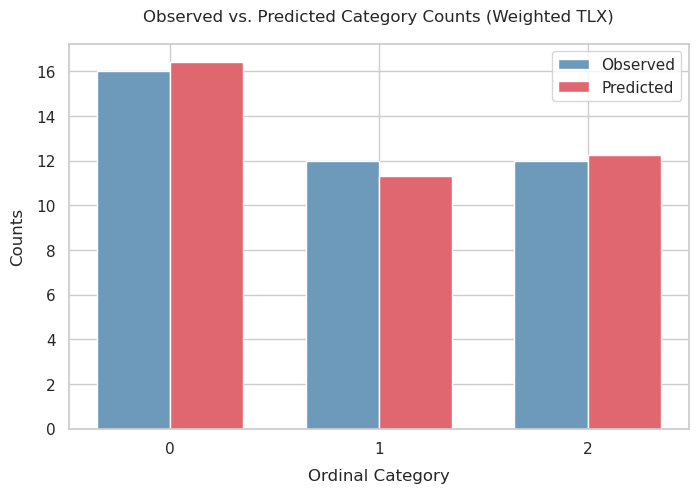

In [77]:
# Aggregate observed and predicted counts across all versions
total_observed_counts = sum(observed_counts_by_version.values())
total_predicted_counts = sum(predicted_counts_by_version.values())

categories = np.arange(len(total_observed_counts))  # Ensure the number of categories matches the data
width = 0.35  # Width of the bars

# Define custom colors
observed_color = c1
predicted_color = c2

# Plot combined observed vs predicted counts
plt.figure(figsize=(8, 5))
plt.bar(categories - width/2, total_observed_counts, width, label='Observed', color=observed_color)
plt.bar(categories + width/2, total_predicted_counts, width, label='Predicted', color=predicted_color)
plt.xlabel('Ordinal Category')
plt.ylabel('Counts')
plt.title('Observed vs. Predicted Category Counts (Weighted TLX)')
plt.xticks(categories)
plt.legend()
plt.savefig('observed_vs_predicted_combined.pdf')
plt.show()


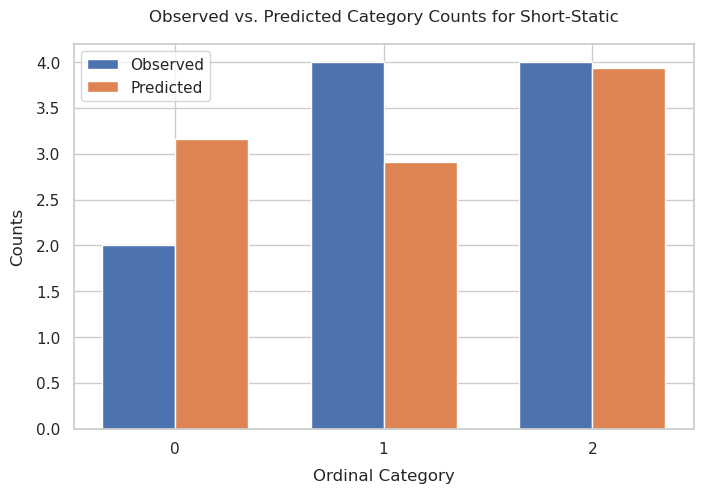

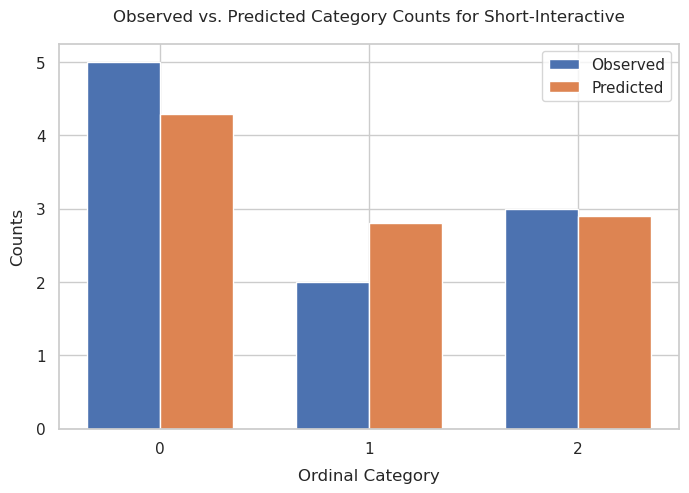

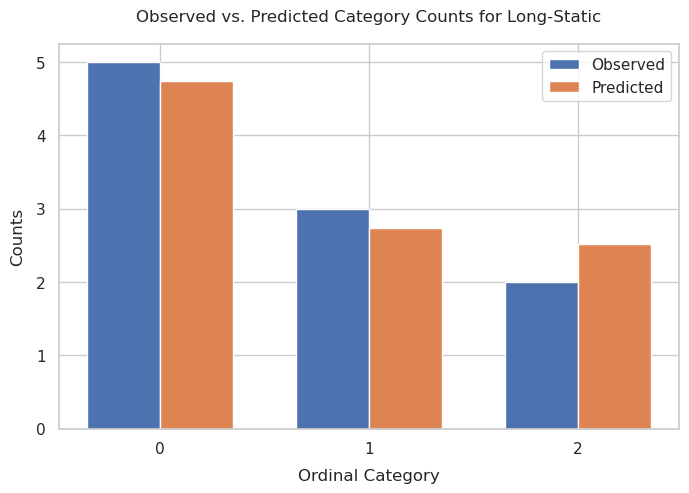

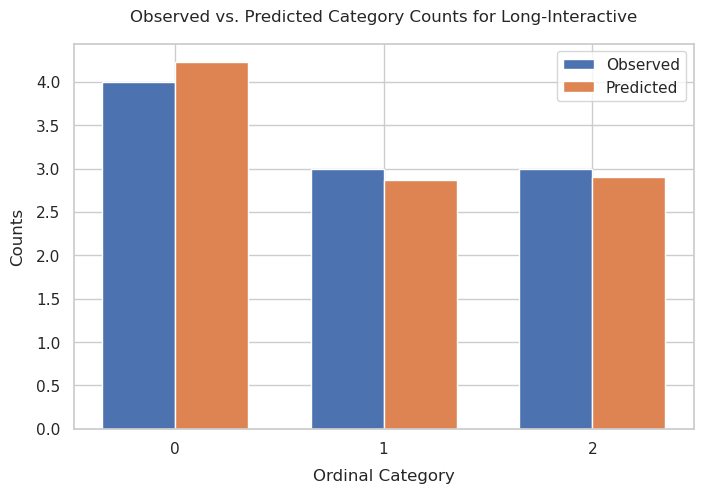

In [78]:
for label in interaction_labels:
    observed_counts = observed_counts_by_version[label]
    predicted_counts = predicted_counts_by_version[label]

    categories = np.arange(num_categories)
    width = 0.35  # Width of the bars

    plt.figure(figsize=(8, 5))
    plt.bar(categories - width/2, observed_counts, width, label='Observed')
    plt.bar(categories + width/2, predicted_counts, width, label='Predicted')
    plt.xlabel('Ordinal Category')
    plt.ylabel('Counts')
    plt.title(f'Observed vs. Predicted Category Counts for {label}')
    plt.xticks(categories)
    plt.legend()
    plt.savefig(f'observed_vs_predicted_{label}.png')
    plt.show()


In [79]:
# Extract posterior samples
posterior_samples = mcmc.get_samples()

# Set up the predictive distribution
predictive = Predictive(ordinal_regression_model, posterior_samples, return_sites=["obs"])

# Generate posterior predictive samples
posterior_predictive = predictive(
    jax.random.PRNGKey(1),
    length_encoded=length_encoded,
    interface_encoded=interface_encoded,
    ordinal_data=None,
    num_categories=num_categories
)

# Extract predicted categories
posterior_predictive_obs = posterior_predictive['obs']


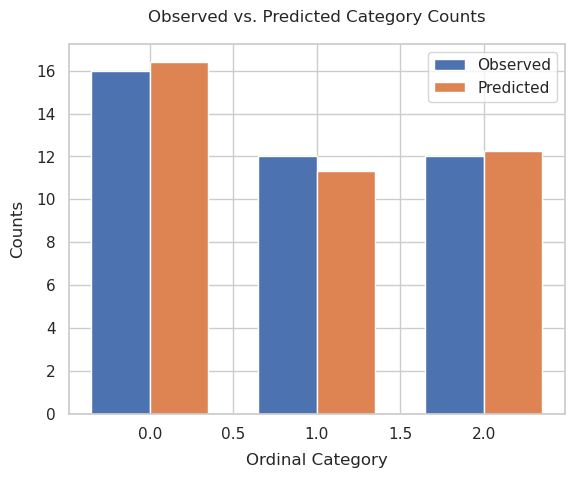

In [80]:
# Observed category counts
observed_counts = np.bincount(np.array(ordinal_data), minlength=num_categories)

# Predicted category counts (average over posterior samples)
predicted_counts = np.mean(
    np.array([np.bincount(sample, minlength=num_categories) for sample in posterior_predictive_obs]),
    axis=0
)

# Plotting
categories = np.arange(num_categories)
width = 0.35

plt.bar(categories - width/2, observed_counts, width, label='Observed')
plt.bar(categories + width/2, predicted_counts, width, label='Predicted')
plt.xlabel('Ordinal Category')
plt.ylabel('Counts')
plt.title('Observed vs. Predicted Category Counts')
plt.legend()
plt.show()


In [81]:
# Define interaction labels corresponding to the versions
interaction_labels = ['v1', 'v2', 'v3', 'v4']

# Define the specific pairs you want to analyze
desired_pairs = [
    ("v3", "v1"),  # Static Short v.s. Interactive Short
    ("v4", "v2"),  # Interactive Long vs. Static Long
    ("v1", "v2"),  # Static Long vs. Static Short
    ("v4", "v3")   # Interactive Long vs. Interactive Short
]

# Initialize a dictionary to store pairwise differences by subscale
pairwise_differences_by_subscale = {}

def compute_pairwise_differences(mean_predictions, pairs):
    pairwise_differences = {}
    for pair in pairs:
        label_diff = f"{pair[0]} - {pair[1]}"
        if pair[0] in mean_predictions and pair[1] in mean_predictions:
            pairwise_differences[label_diff] = mean_predictions[pair[0]] - mean_predictions[pair[1]]
        else:
            raise ValueError(f"One of the versions in the pair {pair} is not present in mean_predictions.")
    return pairwise_differences

def compute_cohens_d(mean_predictions, std_predictions, pairs):
    cohens_d = {}
    for pair in pairs:
        label1, label2 = pair
        label_diff = f"{label1} - {label2}"
        if (label1 in mean_predictions and label2 in mean_predictions and
            label1 in std_predictions and label2 in std_predictions):
            sigma_pooled = jnp.sqrt((std_predictions[label1]**2 + std_predictions[label2]**2) / 2)
            d = (mean_predictions[label1] - mean_predictions[label2]) / sigma_pooled
            cohens_d[label_diff] = d
        else:
            raise ValueError(f"One of the versions in the pair {pair} is missing mean or std predictions.")
    return cohens_d

def compute_odds_ratios(mean_eta_predictions, pairs):
    """
    Compute odds ratios by exponentiating the differences in mean eta predictions.

    Args:
        mean_eta_predictions (dict): mean eta per version per sample (shape: samples)
        pairs (list of tuples): pairs of (label1, label2)

    Returns:
        dict: Dictionary with pairwise OR labels as keys and arrays of OR values per sample as values.
    """
    odds_ratios = {}
    for pair in pairs:
        label_diff = f"{pair[0]} - {pair[1]}"
        if pair[0] in mean_eta_predictions and pair[1] in mean_eta_predictions:
            # Compute log-odds difference
            log_odds_diff = mean_eta_predictions[pair[0]] - mean_eta_predictions[pair[1]]
            # Exponentiate to get odds ratio
            odds_ratios[label_diff] = jnp.exp(log_odds_diff)
        else:
            raise ValueError(f"One of the versions in the pair {pair} is not present in mean_eta_predictions.")
    return odds_ratios



# ----- Pairwise Differences for Observed Categories ('obs') -----
pred_obs = post_pred_samples["obs"]  # (num_samples, num_observations)
grouped_predictions = {
    label: pred_obs[:, interaction_encoded == i]
    for i, label in enumerate(interaction_labels)
}

mean_predictions = {
    label: jnp.mean(samples, axis=1)
    for label, samples in grouped_predictions.items()
}

std_predictions = {
    label: jnp.std(samples, axis=1)
    for label, samples in grouped_predictions.items()
}

# Differences and Cohen's d for observed categories
pairwise_differences_obs = compute_pairwise_differences(mean_predictions, desired_pairs)
idata_diff_obs = az.from_dict(posterior=pairwise_differences_obs)

cohens_d_obs = compute_cohens_d(mean_predictions, std_predictions, desired_pairs)
idata_cohens_d_obs = az.from_dict(posterior=cohens_d_obs)

subscale = 'Weighted_Rate'
pairwise_differences_by_subscale[f"{subscale}_obs"] = idata_diff_obs
pairwise_differences_by_subscale[f"{subscale}_cohensd_obs"] = idata_cohens_d_obs

# ----- Pairwise Differences for Latent `eta` -----
eta_samples = post_pred_samples["eta"]  # (num_samples, num_observations)
grouped_eta = {
    label: eta_samples[:, interaction_encoded == i]
    for i, label in enumerate(interaction_labels)
}

mean_eta_predictions = {
    label: jnp.mean(samples, axis=1)
    for label, samples in grouped_eta.items()
}

std_eta_predictions = {
    label: jnp.std(samples, axis=1)
    for label, samples in grouped_eta.items()
}

pairwise_eta_differences = compute_pairwise_differences(mean_eta_predictions, desired_pairs)
idata_eta_diff = az.from_dict(posterior=pairwise_eta_differences)

cohens_d_eta = compute_cohens_d(mean_eta_predictions, std_eta_predictions, desired_pairs)
idata_cohens_d_eta = az.from_dict(posterior=cohens_d_eta)

# Compute odds ratios from eta differences
pairwise_odds_ratios = compute_odds_ratios(mean_eta_predictions, desired_pairs)
idata_or = az.from_dict(posterior=pairwise_odds_ratios)

pairwise_differences_by_subscale[f"{subscale}_eta"] = idata_eta_diff
pairwise_differences_by_subscale[f"{subscale}_cohensd_eta"] = idata_cohens_d_eta
pairwise_differences_by_subscale[f"{subscale}_or"] = idata_or

# Now you can use az.plot_posterior on `idata_or` to visualize the posterior of odds ratios.


### Selection
Here we plot the difference in eta, which represents the "latent" variable of the model.

In [82]:
pairwise_differences_by_subscale['Weighted_Rate_eta']

Inference data with groups:
	> posterior

In [83]:
desired_order=['v3 - v1', 'v4 - v2', 'v1 - v2', 'v4 - v3']
name_mapping = {
    'v3 - v1': 'Long Text vs.\nShort Text',
    'v4 - v2': 'Long 2-Phase vs.\nShort 2-Phase',
    'v1 - v2': 'Short Text vs.\nShort 2-Phase',
    'v4 - v3': 'Long 2-Phase vs.\nLong Text'
}

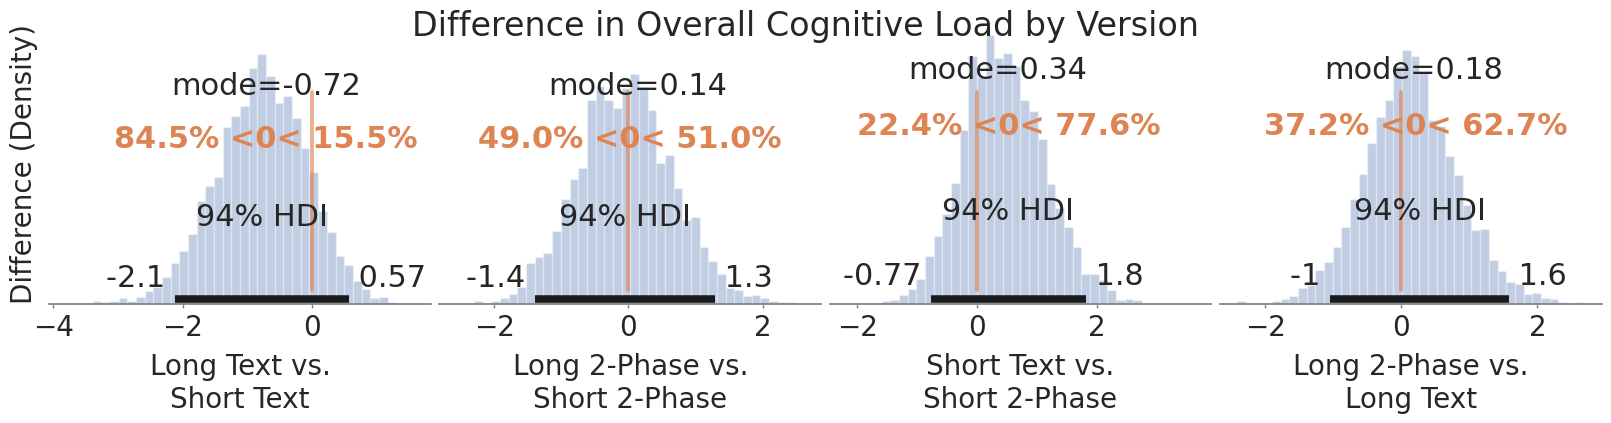

In [84]:
# Prepare figure layout for a single row
n_cols = len(desired_order)  # Number of comparisons
fig, axes = plt.subplots(
    1, n_cols, figsize=(n_cols * 4, 4), sharey=True, constrained_layout=True
)

# Define histogram bin size
bin_size = 40

# Create plots for the single row (difference plots)
for i, label in enumerate(desired_order):
    az.plot_posterior(
        pairwise_differences_by_subscale[f"{subscale}_eta"],
        var_names=[label],
        ax=axes[i],
        hdi_prob=0.94,
        point_estimate="mode",
        ref_val=0,
        kind="hist",
        bins=bin_size,
        textsize=20,
    )
    axes[i].set_title("", fontsize=18)
    axes[i].grid(axis="x", linestyle="", alpha=0.6)  # X-axis grid lines only
    axes[i].grid(axis="y", linestyle="", alpha=0.0)  # No Y-axis grid lines

# Adjust labels and layout
axes[0].set_ylabel("Difference (Density)", fontsize=20)

# Set x-axis labels with the version names
for i in range(n_cols):
    axes[i].set_xlabel(name_mapping[desired_order[i]], fontsize=20)

# Set overall plot title
plt.suptitle("Difference in Overall Cognitive Load by Version", fontsize=24, y=1.02)

# Save the plot
plt.savefig(f"{path}/weighted_cog_version_single_row.pdf", bbox_inches='tight')

# Show the plot
plt.show()


### Subscales
With the same model, we apply it to the remaining subscales
Since there is no exisiting cutpoints, we create weighted bins for each subscale

In [85]:
# subscale_columns = ['Mental_Weighted', 'Physical_Weighted', 'Temporal_Weighted', 'Performance_Weighted', 'Effort_Weighted', 'Frustration_Weighted']
subscale_columns = ['Mental', 'Physical', 'Temporal', 'Performance', 'Effort', 'Frustration']

In [86]:
max=101
# give me count of each category in subscales, bin by 5s
for subscale in subscale_columns:
    tmp_df = nasatlx[subscale].copy()
    # create a dictionary of number of counts for each incremens of 5
    count_dict = {}
    for i in range(0, max, 5):
        count_dict[i] = tmp_df[tmp_df.between(i, i+5)].count()
    print(count_dict)


{0: 0, 5: 0, 10: 0, 15: 3, 20: 9, 25: 9, 30: 6, 35: 6, 40: 4, 45: 1, 50: 2, 55: 8, 60: 7, 65: 4, 70: 5, 75: 4, 80: 4, 85: 4, 90: 2, 95: 1, 100: 1}
{0: 30, 5: 24, 10: 7, 15: 4, 20: 1, 25: 2, 30: 1, 35: 0, 40: 0, 45: 1, 50: 1, 55: 0, 60: 0, 65: 0, 70: 0, 75: 0, 80: 0, 85: 0, 90: 0, 95: 0, 100: 0}
{0: 11, 5: 15, 10: 15, 15: 8, 20: 5, 25: 5, 30: 1, 35: 1, 40: 3, 45: 4, 50: 3, 55: 2, 60: 1, 65: 0, 70: 0, 75: 1, 80: 1, 85: 0, 90: 0, 95: 0, 100: 0}
{0: 5, 5: 11, 10: 12, 15: 10, 20: 11, 25: 9, 30: 6, 35: 4, 40: 1, 45: 4, 50: 5, 55: 1, 60: 0, 65: 0, 70: 0, 75: 0, 80: 0, 85: 0, 90: 0, 95: 0, 100: 0}
{0: 2, 5: 4, 10: 5, 15: 7, 20: 6, 25: 4, 30: 3, 35: 2, 40: 1, 45: 2, 50: 6, 55: 5, 60: 8, 65: 9, 70: 2, 75: 1, 80: 4, 85: 4, 90: 1, 95: 2, 100: 2}
{0: 15, 5: 16, 10: 8, 15: 7, 20: 5, 25: 3, 30: 1, 35: 1, 40: 1, 45: 4, 50: 4, 55: 2, 60: 3, 65: 2, 70: 2, 75: 2, 80: 1, 85: 0, 90: 0, 95: 0, 100: 0}


In [87]:
def create_bins_from_counts(count_dict, min_count):
    """
    Creates bins based on cumulative counts to ensure each bin has at least min_count observations.
    Removes any bins with zero counts.

    Parameters:
    - count_dict: Dictionary with scores as keys and counts as values.
    - min_count: Minimum number of observations desired in each bin.

    Returns:
    - bins: List of tuples representing the bin ranges (start, end).
    - bin_counts: List of total counts in each bin.
    """
    # Sort the count dictionary by score
    sorted_counts = sorted(count_dict.items())  # [(score, count), ...]

    bins = []
    bin_counts = []
    cumulative_count = 0
    bin_start = sorted_counts[0][0]  # Initialize start of first bin

    for i, (score, count) in enumerate(sorted_counts):
        cumulative_count += count

        # Check if the current bin meets the minimum count
        if cumulative_count >= min_count:
            bin_end = score  # End of the current bin
            bins.append((bin_start, bin_end))
            bin_counts.append(cumulative_count)
            cumulative_count = 0  # Reset for the next bin
            if i + 1 < len(sorted_counts):
                bin_start = sorted_counts[i + 1][0]  # Start next bin
        elif i == len(sorted_counts) - 1:
            # Handle remaining counts for the final bin
            bin_end = score
            bins.append((bin_start, bin_end))
            bin_counts.append(cumulative_count)

    # Remove bins with zero counts
    filtered_bins = [(bin_start, bin_end) for (bin_start, bin_end), count in zip(bins, bin_counts) if count > 0]
    filtered_counts = [count for count in bin_counts if count > 0]

    return filtered_bins, filtered_counts


In [88]:
# subscale_data
subscale_binned_data = {}
min_count = 10

for subscale in subscale_columns:
    # counter the number of counts for each increment of 5:
    count_dict = {}
    for i in range(0, max, 5):
        count_dict[i] = nasatlx[subscale].between(i, i+5).sum()

    # create bins
    bins, bin_counts = create_bins_from_counts(count_dict, min_count)
    subscale_binned_data[subscale] = (bins, bin_counts)

In [89]:
# Dictionary to store MCMC objects
mcmc_results = {}

# Loop through each subscale in the dictionary
for subscale, (bins, counts) in subscale_binned_data.items():
    print(f"\nProcessing subscale: {subscale}")

    # Flatten bin ranges into start and end points
    flat_bins = [bin[0] for bin in bins] + [bins[-1][1]]  # Start of each bin + end of the last bin

    # Adjust the last bin to include the maximum value in the data
    max_value = nasatlx[subscale].max()
    if max_value >= flat_bins[-1]:
        flat_bins[-1] = max_value + 1  # Extend the last bin to include the maximum value

    labels = list(range(len(bins)))  # Labels: 0, 1, ..., len(bins)-1

    # Dynamically create the new column name
    bin_column_name = f"{subscale}_bin"

    # Apply binning to the subscale data
    nasatlx[bin_column_name] = pd.cut(
        nasatlx[subscale],
        bins=flat_bins,
        labels=labels,
        include_lowest=True,
        right=False  # Ensure bins are left-inclusive
    )

    print(f"Bin ranges for {subscale}:")
    for i, (start, end) in enumerate(bins):
        print(f"Bin {i}: {start} - {end}")
    # print labels
    print(f"Labels: {labels}")
    print(len(labels))

    # Handle NaN values caused by values outside bin ranges
    nan_values = nasatlx[nasatlx[bin_column_name].isna()]
    if not nan_values.empty:
        # Re-check and fix remaining NaN values (unlikely after adjusting bins)
        nasatlx[bin_column_name] = nasatlx[bin_column_name].cat.add_categories([-1]).fillna(-1)

    # Convert to integer for ordinal regression
    nasatlx[bin_column_name] = nasatlx[bin_column_name].astype(int)

    # Prepare inputs for the model
    ordinal_data = jnp.array(nasatlx[bin_column_name].values)
    length_encoded = jnp.array(nasatlx['Options_Encoded'].values)
    interface_encoded = jnp.array(nasatlx['Interface_Encoded'].values)
    num_categories = len(labels)  # Number of ordinal categories for the subscale

    # Define the MCMC sampler
    nuts_kernel = NUTS(ordinal_regression_model, target_accept_prob=0.95)
    mcmc = MCMC(nuts_kernel, num_warmup=5000, num_samples=2000, num_chains=2)

    # Run the model for the current subscale
    mcmc.run(
        jax.random.PRNGKey(0),
        length_encoded=length_encoded,
        interface_encoded=interface_encoded,
        ordinal_data=ordinal_data,
        num_categories=num_categories
    )

    # Save the MCMC object in the dictionary
    mcmc_results[subscale] = mcmc

    # Print summary results
    print(f"\nResults for {subscale}:")
    mcmc.print_summary()



Processing subscale: Mental
Bin ranges for Mental:
Bin 0: 0 - 20
Bin 1: 25 - 30
Bin 2: 35 - 40
Bin 3: 45 - 55
Bin 4: 60 - 65
Bin 5: 70 - 80
Bin 6: 85 - 100
Labels: [0, 1, 2, 3, 4, 5, 6]
7


/tmp/ipykernel_6197/3144665661.py:54: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts_kernel, num_warmup=5000, num_samples=2000, num_chains=2)
sample: 100%|██████████| 7000/7000 [00:03<00:00, 2112.87it/s, 31 steps of size 9.96e-02. acc. prob=0.94]
/tmp/ipykernel_6197/3144665661.py:54: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts_kernel, num_warmup=5000, num_samples=2000, n


Results for Mental:

                            mean       std    median      5.0%     95.0%     n_eff     r_hat
          L_Omega[0,0]      1.00      0.00      1.00      1.00      1.00       nan       nan
          L_Omega[0,1]      0.00      0.00      0.00      0.00      0.00       nan       nan
          L_Omega[1,0]      0.02      0.44      0.02     -0.69      0.75   3373.68      1.00
          L_Omega[1,1]      0.89      0.14      0.94      0.69      1.00   2096.61      1.00
                 alpha      0.52      0.92      0.54     -1.10      1.96   3156.19      1.00
 beta_interface_raw[0]      0.28      0.87      0.28     -1.21      1.63   2840.98      1.00
 beta_interface_raw[1]      0.05      0.89      0.09     -1.44      1.49   2808.86      1.00
           beta_length      0.18      0.66      0.17     -0.94      1.25   2690.22      1.00
          cutpoints[0]     -0.51      0.90     -0.52     -2.00      0.95   2804.24      1.00
          cutpoints[1]      1.00      0.98      

sample: 100%|██████████| 7000/7000 [00:03<00:00, 2101.87it/s, 31 steps of size 8.54e-02. acc. prob=0.97] 
/tmp/ipykernel_6197/3144665661.py:54: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts_kernel, num_warmup=5000, num_samples=2000, num_chains=2)



Results for Physical:

                            mean       std    median      5.0%     95.0%     n_eff     r_hat
          L_Omega[0,0]      1.00      0.00      1.00      1.00      1.00       nan       nan
          L_Omega[0,1]      0.00      0.00      0.00      0.00      0.00       nan       nan
          L_Omega[1,0]     -0.02      0.43     -0.03     -0.71      0.71   2929.16      1.00
          L_Omega[1,1]      0.89      0.13      0.94      0.70      1.00   1879.92      1.00
                 alpha      0.22      0.89      0.23     -1.13      1.81   3458.13      1.00
 beta_interface_raw[0]     -0.10      0.90     -0.10     -1.64      1.30   2813.91      1.00
 beta_interface_raw[1]      0.25      0.91      0.27     -1.13      1.83   3218.11      1.00
           beta_length      0.38      0.78      0.39     -0.92      1.63   2521.37      1.00
          cutpoints[0]     -0.24      0.93     -0.24     -1.79      1.27   3205.90      1.00
          cutpoints[1]      2.28      1.03    

sample: 100%|██████████| 7000/7000 [00:03<00:00, 1981.87it/s, 31 steps of size 9.75e-02. acc. prob=0.94]
/tmp/ipykernel_6197/3144665661.py:54: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts_kernel, num_warmup=5000, num_samples=2000, num_chains=2)



Results for Temporal:

                            mean       std    median      5.0%     95.0%     n_eff     r_hat
          L_Omega[0,0]      1.00      0.00      1.00      1.00      1.00       nan       nan
          L_Omega[0,1]      0.00      0.00      0.00      0.00      0.00       nan       nan
          L_Omega[1,0]     -0.01      0.44     -0.01     -0.68      0.77   3987.63      1.00
          L_Omega[1,1]      0.89      0.14      0.94      0.69      1.00   1928.86      1.00
                 alpha      0.54      0.91      0.55     -0.88      2.04   3350.41      1.00
 beta_interface_raw[0]      0.04      0.88      0.05     -1.38      1.48   3256.13      1.00
 beta_interface_raw[1]      0.33      0.89      0.32     -1.13      1.78   3080.40      1.00
           beta_length     -0.32      0.73     -0.32     -1.51      0.87   3034.20      1.00
          cutpoints[0]     -0.55      0.88     -0.56     -2.04      0.81   3765.49      1.00
          cutpoints[1]      0.65      0.93    

sample: 100%|██████████| 7000/7000 [00:03<00:00, 2120.31it/s, 31 steps of size 1.03e-01. acc. prob=0.94] 
/tmp/ipykernel_6197/3144665661.py:54: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts_kernel, num_warmup=5000, num_samples=2000, num_chains=2)



Results for Performance:

                            mean       std    median      5.0%     95.0%     n_eff     r_hat
          L_Omega[0,0]      1.00      0.00      1.00      1.00      1.00       nan       nan
          L_Omega[0,1]      0.00      0.00      0.00      0.00      0.00       nan       nan
          L_Omega[1,0]     -0.04      0.44     -0.06     -0.77      0.65   4266.95      1.00
          L_Omega[1,1]      0.89      0.13      0.94      0.69      1.00   2039.06      1.00
                 alpha      0.45      0.91      0.46     -1.01      1.98   3453.98      1.00
 beta_interface_raw[0]      0.10      0.89      0.10     -1.33      1.52   3617.21      1.00
 beta_interface_raw[1]      0.19      0.89      0.19     -1.25      1.66   3842.58      1.00
           beta_length      0.01      0.72      0.01     -1.18      1.16   2774.82      1.00
          cutpoints[0]     -0.44      0.91     -0.46     -1.89      1.11   3910.84      1.00
          cutpoints[1]      0.64      0.96 

sample: 100%|██████████| 7000/7000 [00:03<00:00, 1927.00it/s, 31 steps of size 1.05e-01. acc. prob=0.94]
/tmp/ipykernel_6197/3144665661.py:54: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts_kernel, num_warmup=5000, num_samples=2000, num_chains=2)



Results for Effort:

                            mean       std    median      5.0%     95.0%     n_eff     r_hat
          L_Omega[0,0]      1.00      0.00      1.00      1.00      1.00       nan       nan
          L_Omega[0,1]      0.00      0.00      0.00      0.00      0.00       nan       nan
          L_Omega[1,0]      0.02      0.45      0.01     -0.74      0.74   3825.16      1.00
          L_Omega[1,1]      0.88      0.14      0.94      0.67      1.00   2103.21      1.00
                 alpha      0.48      0.91      0.49     -0.92      2.09   3279.38      1.00
 beta_interface_raw[0]      0.20      0.90      0.20     -1.28      1.65   2909.59      1.00
 beta_interface_raw[1]      0.12      0.88      0.15     -1.29      1.59   3118.03      1.00
           beta_length     -0.02      0.65     -0.03     -1.04      1.10   2558.02      1.00
          cutpoints[0]     -0.47      0.90     -0.48     -1.93      1.03   2988.41      1.00
          cutpoints[1]      0.68      0.95      

sample: 100%|██████████| 7000/7000 [00:03<00:00, 1942.95it/s, 31 steps of size 8.46e-02. acc. prob=0.97]



Results for Frustration:

                            mean       std    median      5.0%     95.0%     n_eff     r_hat
          L_Omega[0,0]      1.00      0.00      1.00      1.00      1.00       nan       nan
          L_Omega[0,1]      0.00      0.00      0.00      0.00      0.00       nan       nan
          L_Omega[1,0]      0.02      0.44      0.02     -0.69      0.76   3691.41      1.00
          L_Omega[1,1]      0.89      0.14      0.94      0.68      1.00   1995.78      1.00
                 alpha      0.52      0.91      0.52     -1.00      1.97   4253.15      1.00
 beta_interface_raw[0]      0.16      0.90      0.18     -1.31      1.61   4100.46      1.00
 beta_interface_raw[1]      0.15      0.89      0.18     -1.32      1.61   3988.49      1.00
           beta_length      0.16      0.65      0.15     -0.90      1.21   3853.09      1.00
          cutpoints[0]     -0.49      0.88     -0.49     -1.94      0.94   3761.49      1.00
          cutpoints[1]      1.33      0.96 

### Plot posterior to verify the models

In [90]:
def plot_observed_vs_predicted(observed_counts, predicted_counts, categories, title):
    """
    Plot observed vs. predicted category counts.

    Parameters:
    - observed_counts: Array of observed category counts.
    - predicted_counts: Array of predicted category counts.
    - categories: Array of category labels (e.g., [0, 1, 2, ...]).
    - title: Title of the plot.
    """
    width = 0.35  # Width of the bars
    plt.figure(figsize=(8, 5))
    plt.bar(categories - width / 2, observed_counts, width, label='Observed')
    plt.bar(categories + width / 2, predicted_counts, width, label='Predicted')
    plt.xlabel('Ordinal Category')
    plt.ylabel('Counts')
    plt.title(title)
    plt.xticks(categories)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"img/cog/{title}.pdf")
    plt.show()



Posterior Predictive Checks for Subscale: Mental


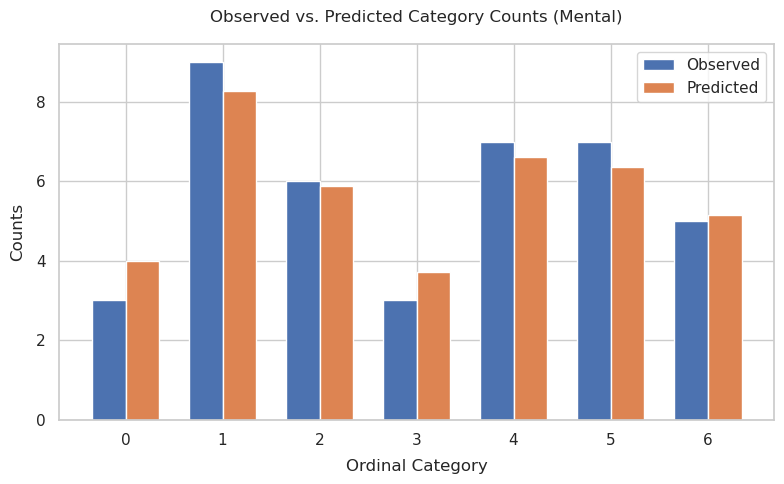

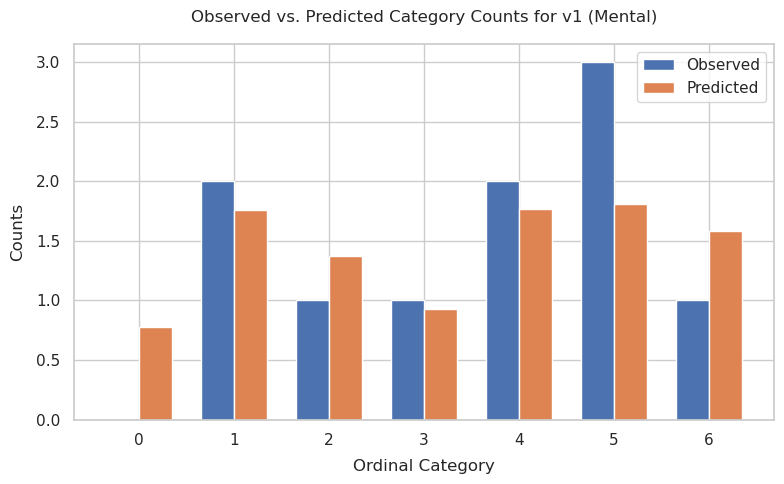

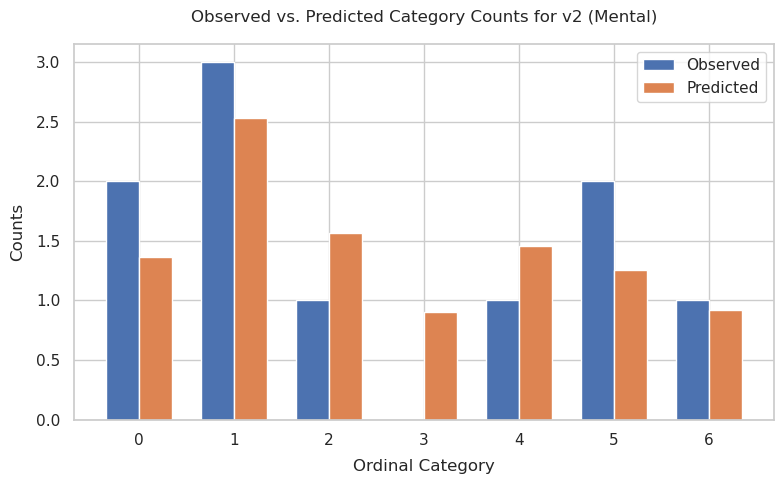

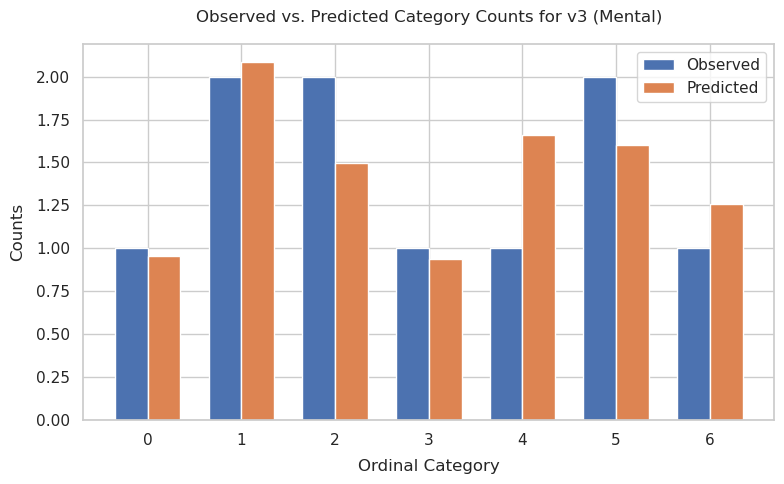

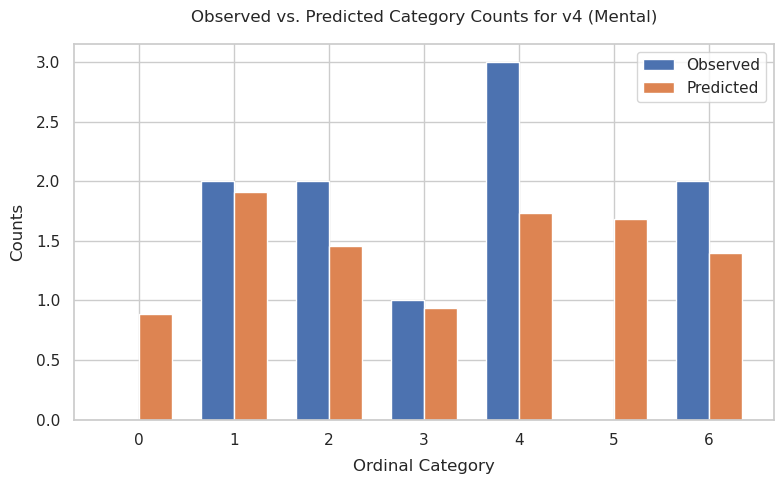


Posterior Predictive Checks for Subscale: Physical


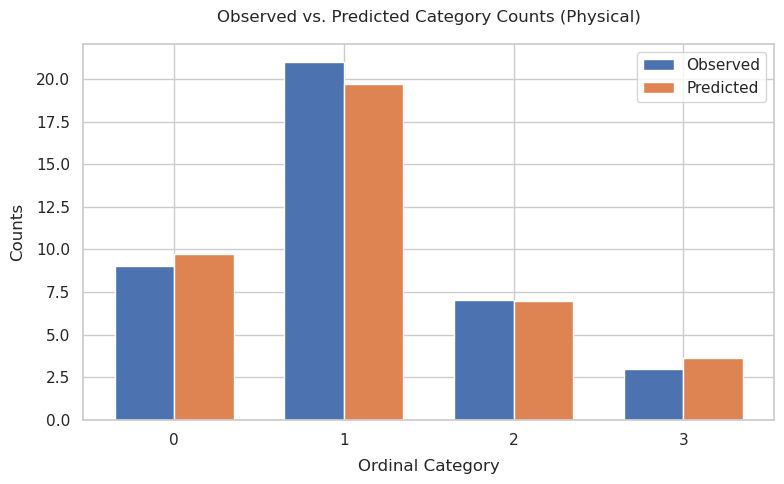

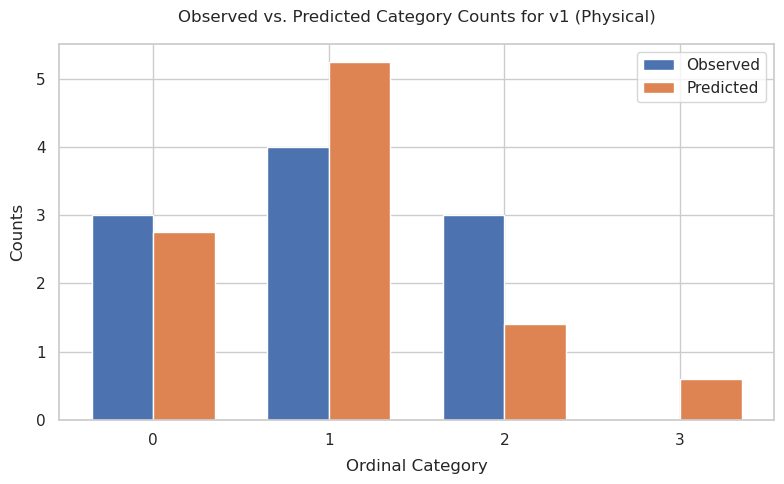

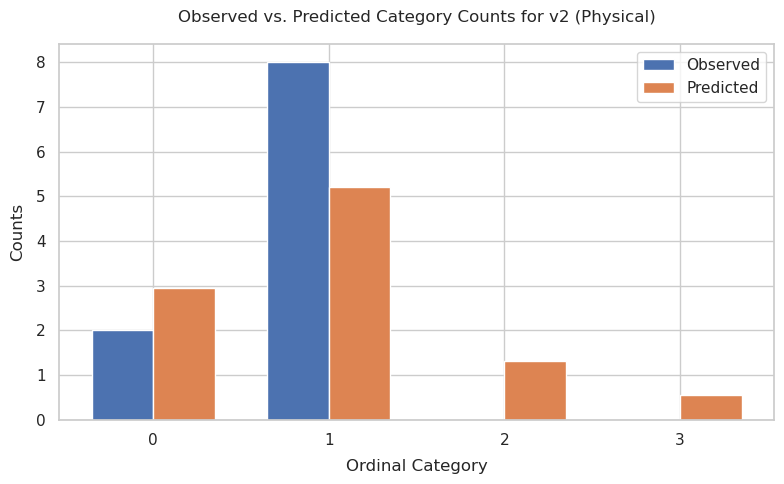

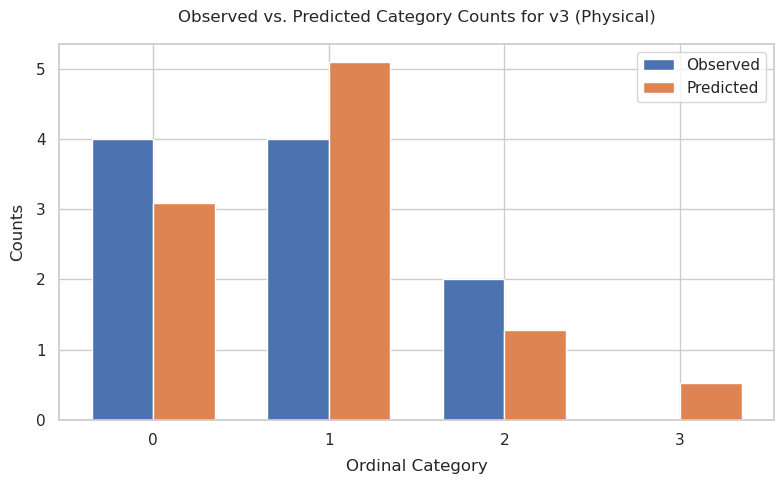

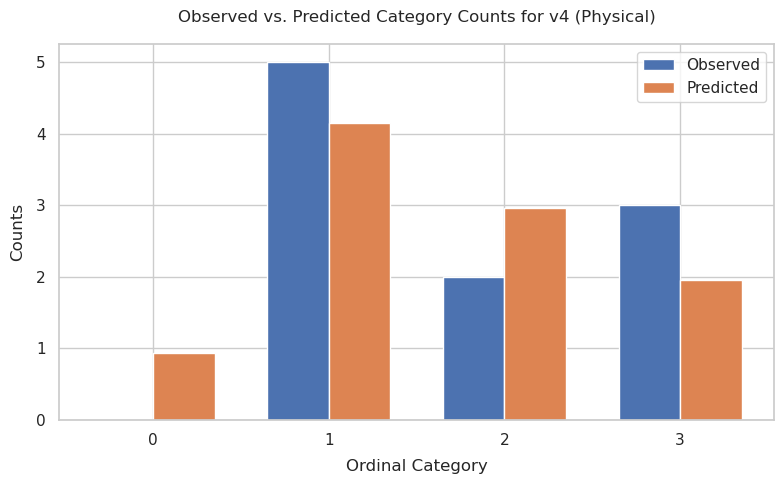


Posterior Predictive Checks for Subscale: Temporal


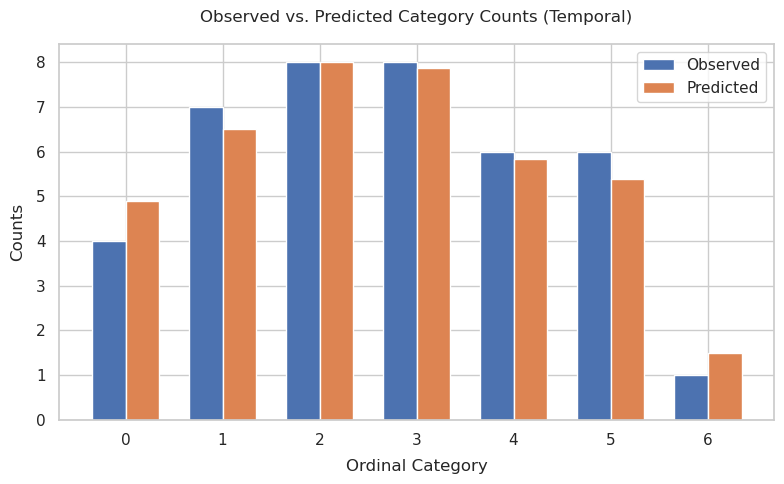

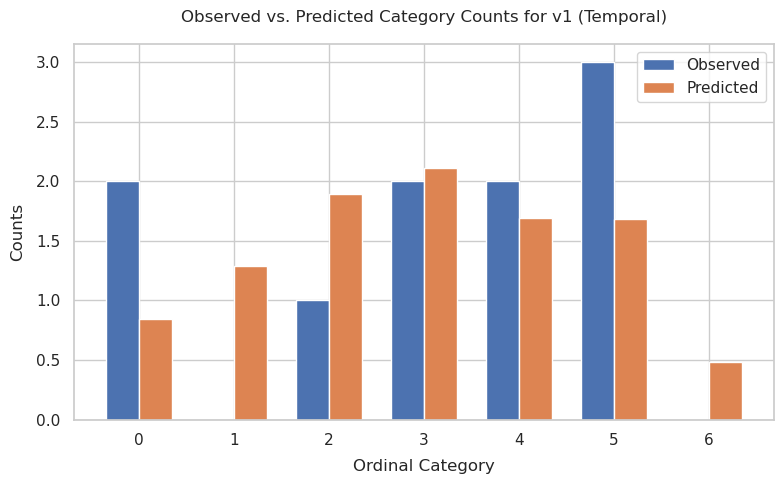

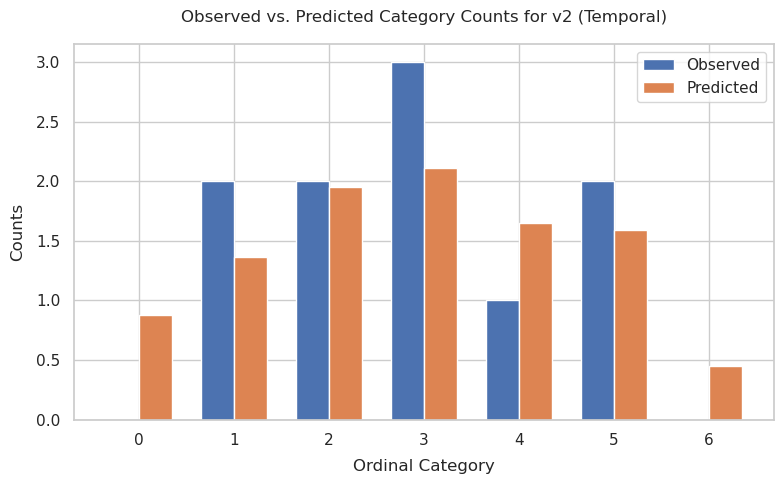

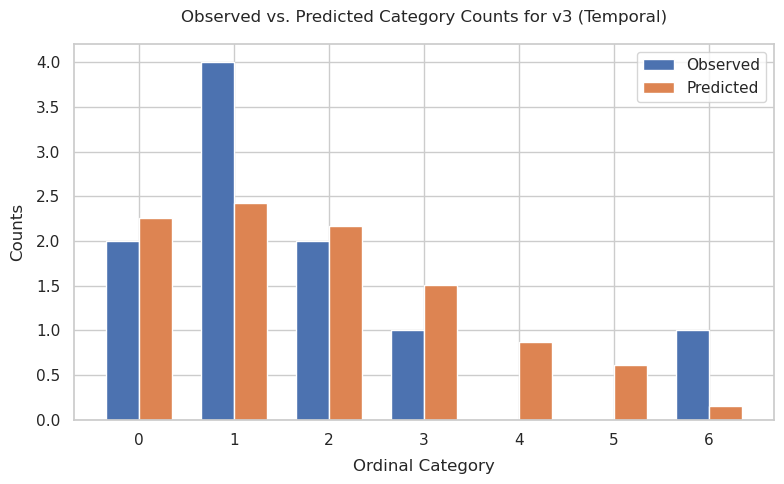

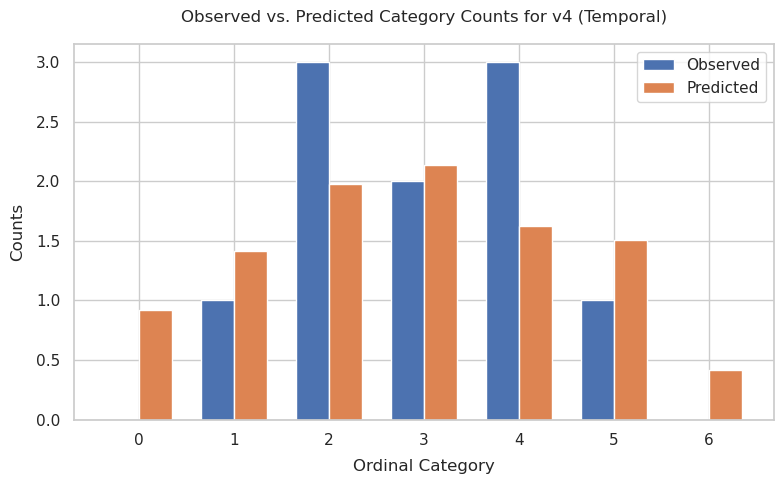


Posterior Predictive Checks for Subscale: Performance


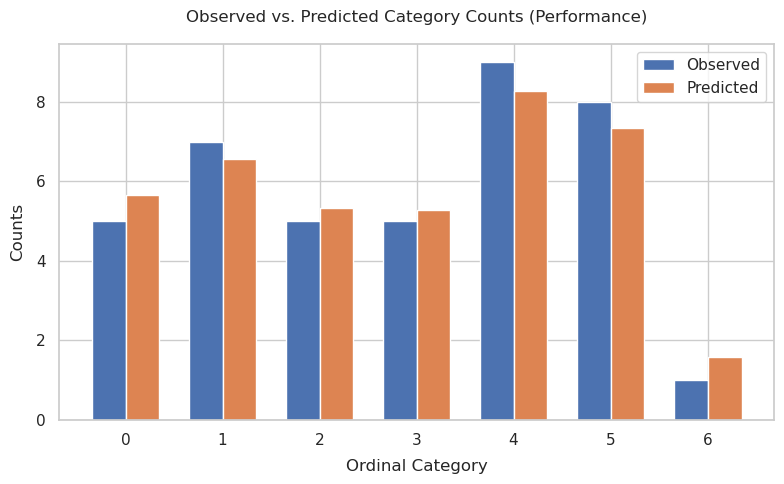

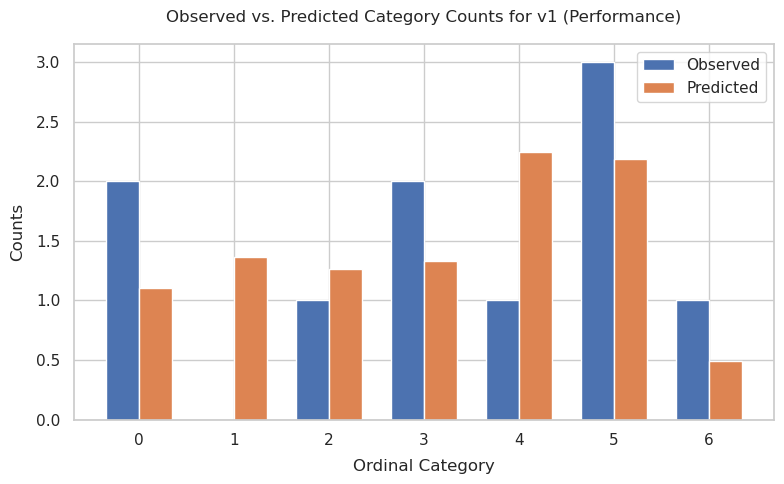

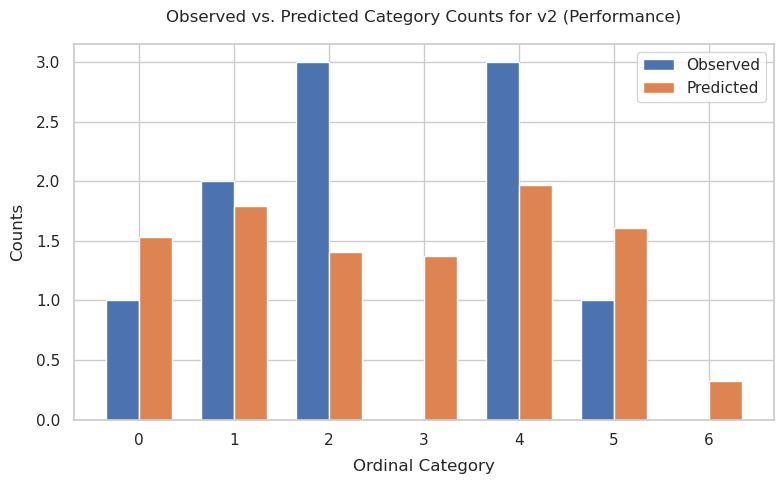

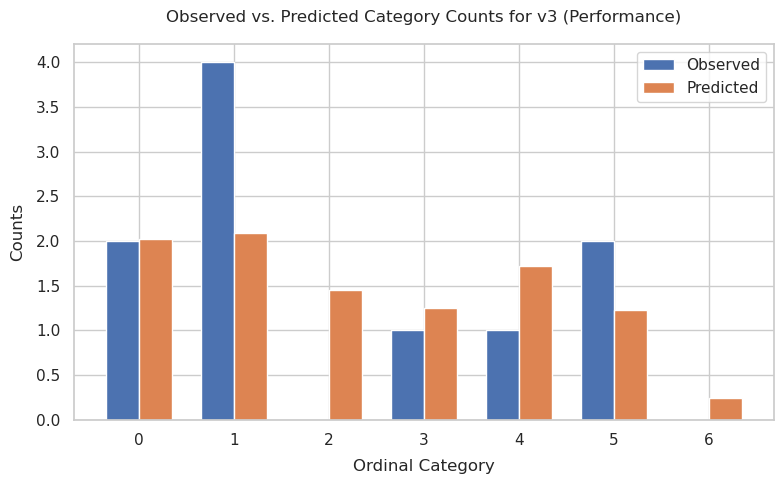

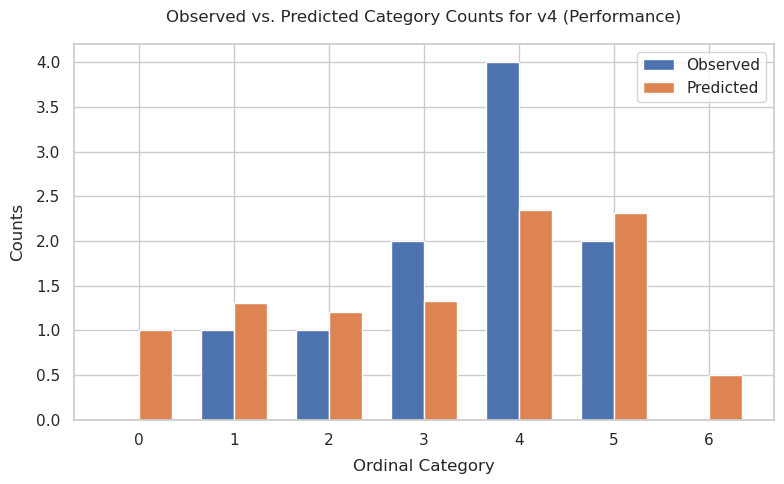


Posterior Predictive Checks for Subscale: Effort


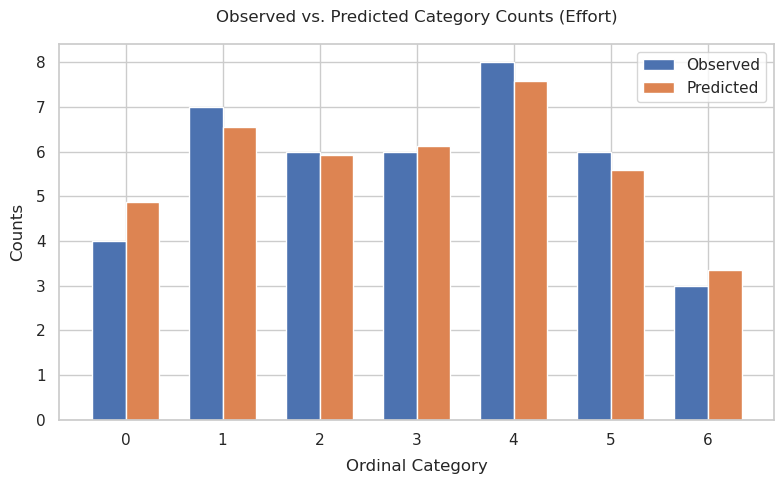

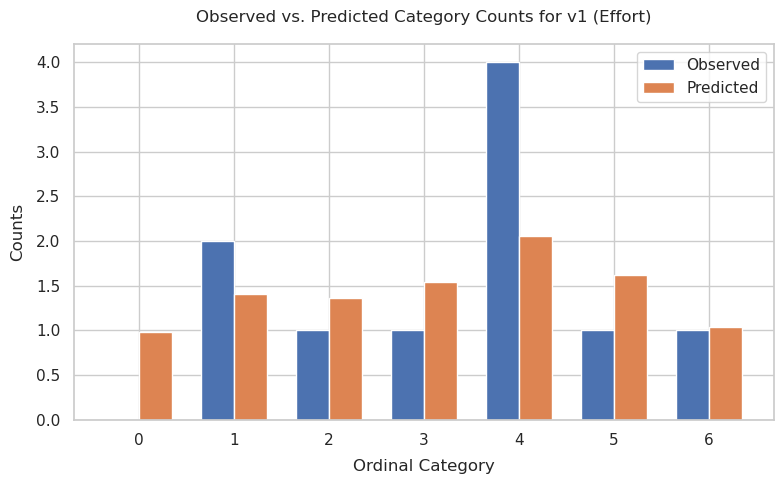

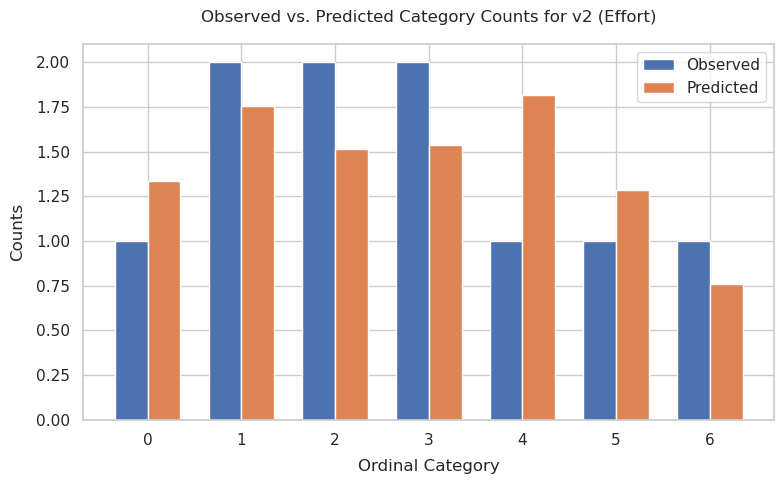

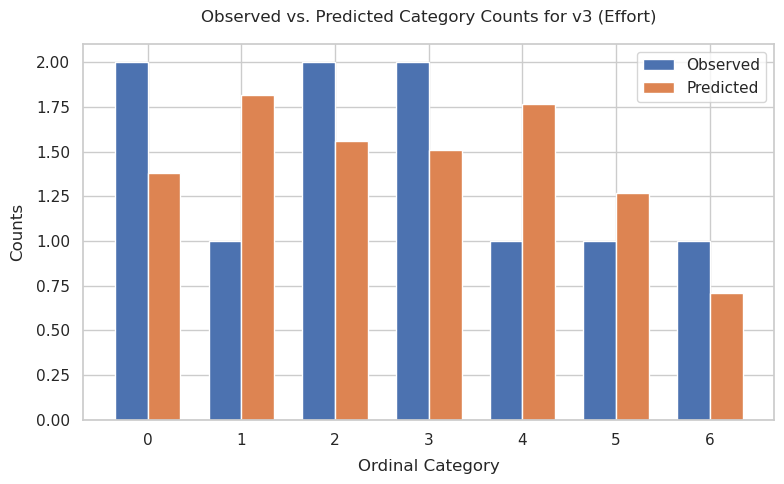

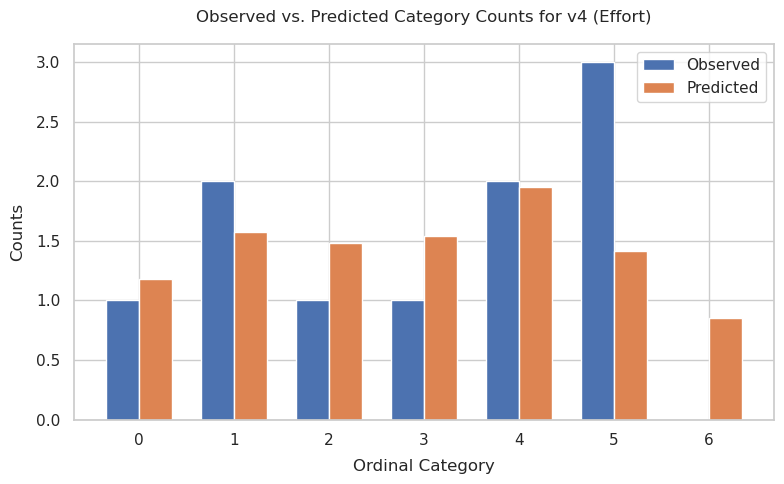


Posterior Predictive Checks for Subscale: Frustration


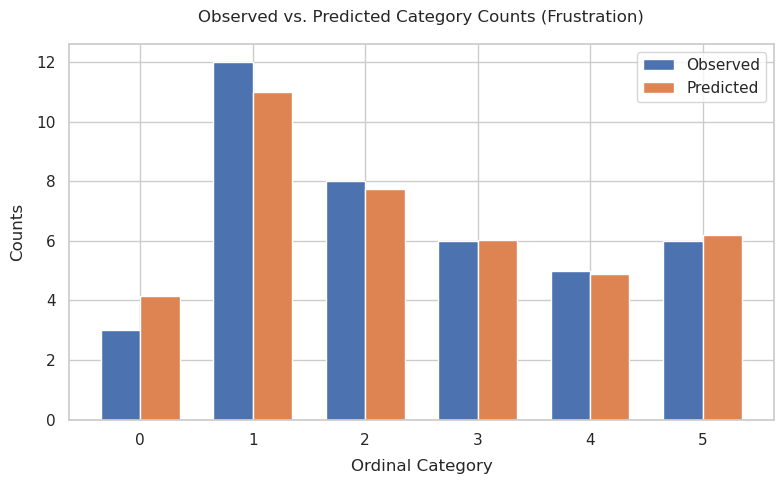

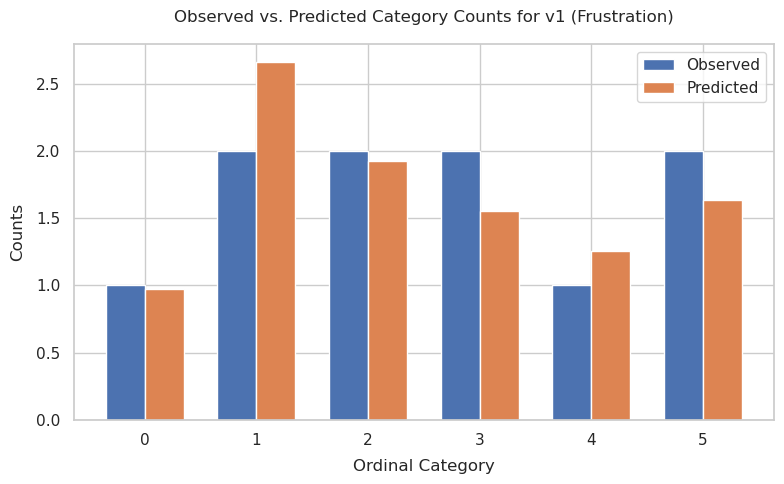

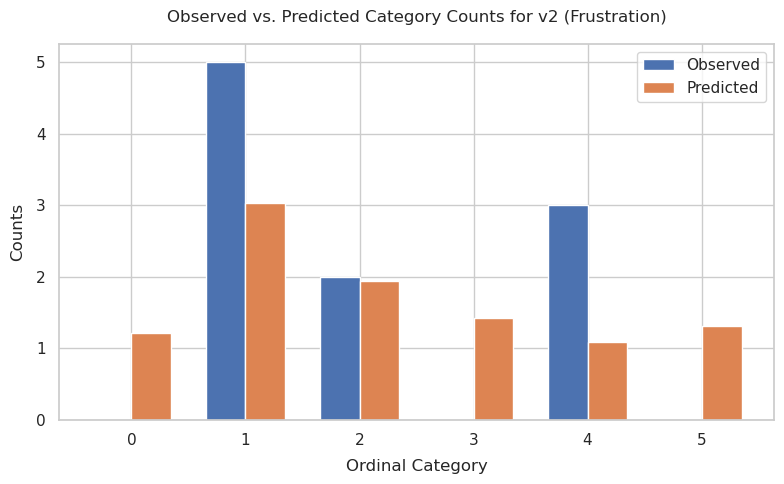

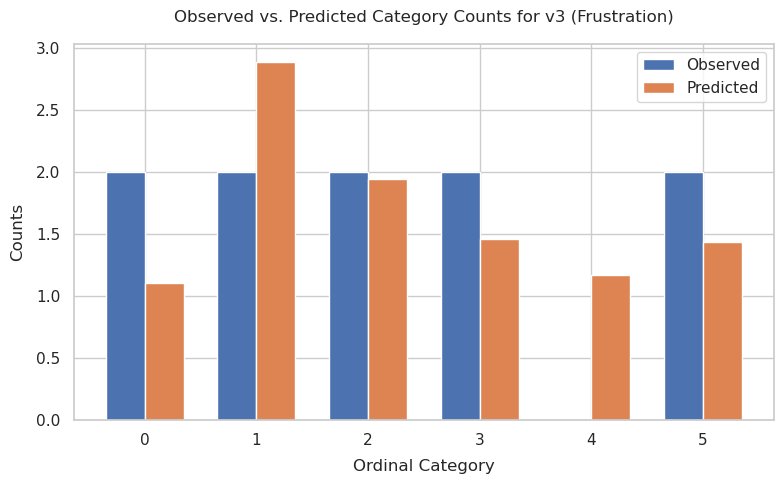

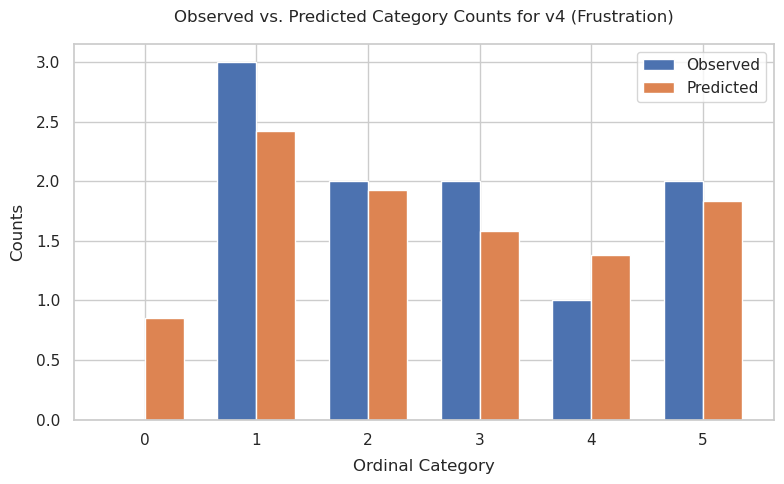

In [91]:
# Loop through MCMC results for each subscale
for subscale, mcmc in mcmc_results.items():
    print(f"\nPosterior Predictive Checks for Subscale: {subscale}")

    # Extract posterior samples
    posterior_samples = mcmc.get_samples()

    # Set up the predictive distribution
    predictive = Predictive(ordinal_regression_model, posterior_samples)

    # get number of categories for the subscale
    num_categories = len(subscale_binned_data[subscale][0])

    # Generate posterior predictive samples
    post_pred_samples = predictive(
        jax.random.PRNGKey(1),
        length_encoded=length_encoded,
        interface_encoded=interface_encoded,
        ordinal_data=None,
        num_categories=num_categories  # Derived from the current subscale's bins
    )

    # Extract predictive samples
    pred_obs = post_pred_samples["obs"]  # Shape: (num_samples, num_observations)

    # Compute observed and predicted counts (overall)
    observed_counts = np.bincount(
        np.array(nasatlx[f"{subscale}_bin"].values),
        minlength=num_categories
    )
    
    predicted_counts = compute_category_counts(pred_obs, num_categories).mean(axis=0)

    # Plot observed vs. predicted (overall)
    categories = np.arange(num_categories)
    plot_observed_vs_predicted(
        observed_counts,
        predicted_counts,
        categories,
        f"Observed vs. Predicted Category Counts ({subscale})"
    )

    # Organize observed and predicted data by version
    observed_data_by_version = {
        interaction_labels[i]: nasatlx[f"{subscale}_bin"].values[interaction_encoded == i]
        for i in range(4)
    }

    predicted_data_by_version = {
        interaction_labels[i]: pred_obs[:, interaction_encoded == i]
        for i in range(4)
    }

    # Loop through each version for version-specific checks
    for label in interaction_labels:
        # Observed counts
        observed_counts_version = np.bincount(
            observed_data_by_version[label],
            minlength=num_categories
        )

        # Predicted counts (average over posterior samples)
        predicted_counts_version = compute_category_counts(
            predicted_data_by_version[label],
            num_categories
        ).mean(axis=0)

        # Plot observed vs. predicted for the specific version
        plot_observed_vs_predicted(
            observed_counts_version,
            predicted_counts_version,
            categories,
            f"Observed vs. Predicted Category Counts for {label} ({subscale})"
        )


In [92]:
c1 = color_exp = sns.diverging_palette(240, 10, n=13)[3]
c2 = color_exp = sns.diverging_palette(240, 10, n=10)[8]
sns.color_palette([c1, c2])

[(0.6032519472587169, 0.7192045852118497, 0.8057262499482123),
 (0.8755994299072009, 0.3865694802828008, 0.42297048713913266)]

In [93]:
plt.rcParams.update({
    'font.size': 16,            # Global font size
    'axes.titlesize': 16,       # Font size of the title
    'axes.labelsize': 16,       # Font size of the x and y labels
    'xtick.labelsize': 16,      # Font size of the x tick labels
    'ytick.labelsize': 16,      # Font size of the y tick labels
    'legend.fontsize': 14,      # Font size of the legend
    'figure.titlesize': 20,     # Font size of the figure title
    'axes.titleweight': 'normal', # Weight of the title
    'axes.labelweight': 'normal', # Weight of the labels
    'axes.titlepad': 16,        # Padding between the axes and title
    'axes.labelpad': 8         # Padding between the axes and labels
})


Posterior Predictive Checks for Subscale: Mental

Posterior Predictive Checks for Subscale: Physical

Posterior Predictive Checks for Subscale: Temporal

Posterior Predictive Checks for Subscale: Performance

Posterior Predictive Checks for Subscale: Effort

Posterior Predictive Checks for Subscale: Frustration


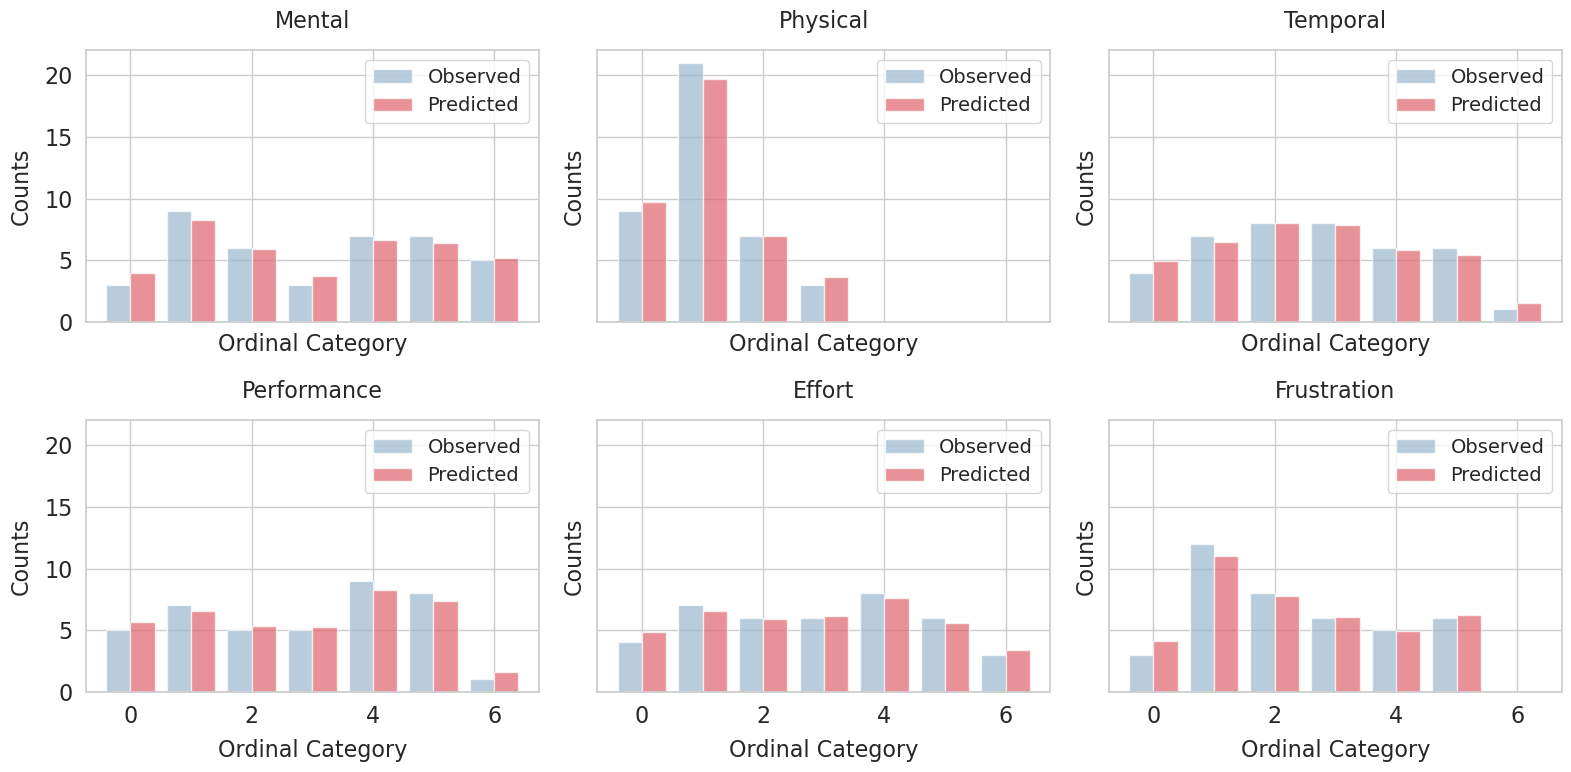

In [94]:
# Define color palettes for observed and predicted bars
observed_colors = [c1, c1, c1, c1, c1, c1]
predicted_colors = [c2, c2, c2, c2, c2, c2]

# Create a 2x3 subplot grid
fig, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=True, sharey=True)

# Loop through MCMC results for each subscale and plot on the grid
for idx, (subscale, mcmc) in enumerate(mcmc_results.items()):
    print(f"\nPosterior Predictive Checks for Subscale: {subscale}")

    # Extract posterior samples
    posterior_samples = mcmc.get_samples()

    # Set up the predictive distribution
    predictive = Predictive(ordinal_regression_model, posterior_samples)

    # Get the number of categories for the subscale
    num_categories = len(subscale_binned_data[subscale][0])

    # Generate posterior predictive samples
    post_pred_samples = predictive(
        jax.random.PRNGKey(1),
        length_encoded=length_encoded,
        interface_encoded=interface_encoded,
        ordinal_data=None,
        num_categories=num_categories  # Derived from the current subscale's bins
    )

    # Extract predictive samples
    pred_obs = post_pred_samples["obs"]  # Shape: (num_samples, num_observations)

    # Compute observed and predicted counts (overall)
    observed_counts = np.bincount(
        np.array(nasatlx[f"{subscale}_bin"].values),
        minlength=num_categories
    )
    
    predicted_counts = compute_category_counts(pred_obs, num_categories).mean(axis=0)

    # Determine subplot location
    row, col = divmod(idx, 3)

    # Plot observed vs. predicted with unique colors
    categories = np.arange(num_categories)
    axes[row, col].bar(categories - 0.2, observed_counts, width=0.4, label="Observed", alpha=0.7, color=observed_colors[idx % len(observed_colors)])
    axes[row, col].bar(categories + 0.2, predicted_counts, width=0.4, label="Predicted", alpha=0.7, color=predicted_colors[idx % len(predicted_colors)])
    axes[row, col].set_title(f"{subscale}")
    axes[row, col].set_xlabel("Ordinal Category")
    axes[row, col].set_ylabel("Counts")
    axes[row, col].legend()

# Adjust layout for better display
plt.tight_layout()
plt.savefig(f"{path}/observed_vs_predicted_all_subscale.pdf")
plt.savefig(f"{path}/observed_vs_predicted_all_subscale.png")
plt.show()


In [95]:
# Define interaction labels corresponding to the versions
interaction_labels = ['v1', 'v2', 'v3', 'v4']

# Define the specific pairs you want to analyze
desired_pairs = [
    ("v3", "v1"),  # Interactive Short vs. Static Short
    ("v4", "v2"),  # Interactive Long vs. Static Long
    ("v1", "v2"),  # Static Long vs. Static Short
    ("v4", "v3")   # Interactive Long vs. Interactive Short
]

# Initialize a dictionary to store pairwise differences by subscale
pairwise_differences_by_subscale = {}

# # Recreate interaction_encoded if not already defined
# length_encoded = nasatlx['Options_Encoded'].values  # 0 or 1
# interface_encoded = nasatlx['Interface_Encoded'].values  # 0 or 1
# interaction_encoded = length_encoded * 2 + interface_encoded  # 0 to 3

# ----- Function to Compute Pairwise Differences -----
def compute_pairwise_differences(mean_predictions, pairs):
    """
    Compute pairwise differences for specified version pairs.

    Args:
        mean_predictions (dict): Dictionary with version labels as keys and mean predictions as values.
        pairs (list of tuples): List of tuples specifying the pairs to compare (e.g., [("v2", "v1"), ...]).

    Returns:
        dict: Dictionary with pairwise difference labels as keys and difference arrays as values.
    """
    pairwise_differences = {}
    for pair in pairs:
        label_diff = f"{pair[0]} - {pair[1]}"
        if pair[0] in mean_predictions and pair[1] in mean_predictions:
            pairwise_differences[label_diff] = mean_predictions[pair[0]] - mean_predictions[pair[1]]
        else:
            raise ValueError(f"One of the versions in the pair {pair} is not present in mean_predictions.")
    return pairwise_differences

def compute_cohens_d(mean_predictions, std_predictions, pairs):
    """
    Compute Cohen's d for specified version pairs.

    Args:
        mean_predictions (dict): Dictionary with version labels as keys and arrays of mean predictions.
        std_predictions (dict): Dictionary with version labels as keys and arrays of standard deviations.
        pairs (list of tuples): List of tuples specifying the pairs to compare.

    Returns:
        dict: Dictionary with pairwise Cohen's d labels as keys and arrays of Cohen's d values as values.
    """
    cohens_d = {}
    for pair in pairs:
        label1, label2 = pair
        label_diff = f"{label1} - {label2}"
        if (label1 in mean_predictions and label2 in mean_predictions and
            label1 in std_predictions and label2 in std_predictions):
            # Compute pooled std for each sample
            sigma_pooled = jnp.sqrt((std_predictions[label1]**2 + std_predictions[label2]**2) / 2)
            d = (mean_predictions[label1] - mean_predictions[label2]) / sigma_pooled
            cohens_d[label_diff] = d
        else:
            raise ValueError(f"One of the versions in the pair {pair} is missing mean or std predictions.")
    return cohens_d

### subscale differences

In [96]:
for s in subscale_columns:

    # Extract posterior samples
    posterior_samples = mcmc_results[s].get_samples()

    # Set up the predictive distribution
    predictive = Predictive(ordinal_regression_model, posterior_samples, return_sites=["obs"])

    # Generate posterior predictive samples
    posterior_predictive = predictive(
        jax.random.PRNGKey(1),
        length_encoded=length_encoded,
        interface_encoded=interface_encoded,
        ordinal_data=None,
        num_categories=num_categories
    )

    # Extract predicted categories
    pred_obs = posterior_predictive['obs']


    # ----- Pairwise Differences for Observed Categories ('obs') -----
    # Extract predictive samples for 'obs'
    # pred_obs = post_pred_samples["obs"]  # Shape: (num_samples, num_observations)

    # Group predictions by interaction level (0 to 3 corresponding to v1 to v4)
    grouped_predictions = {
        label: pred_obs[:, interaction_encoded == i]
        for i, label in enumerate(interaction_labels)
    }

    # Compute mean predicted category for each version across samples
    mean_predictions = {
        label: jnp.mean(samples, axis=1)  # Mean over observations in the version
        for label, samples in grouped_predictions.items()
    }

    std_predictions = {
        label: jnp.std(samples, axis=1)   # Std dev over observations in the version per sample
        for label, samples in grouped_predictions.items()
    }

    # Compute pairwise differences for the versions ('obs') using desired_pairs
    pairwise_differences_obs = compute_pairwise_differences(mean_predictions, desired_pairs)
    idata_diff_obs = az.from_dict(posterior=pairwise_differences_obs)

    cohens_d_obs = compute_cohens_d(mean_predictions, std_predictions, desired_pairs)
    idata_cohens_d_obs = az.from_dict(posterior=cohens_d_obs)

    # Store the pairwise differences for the subscale (assuming 'Weighted_Rate')
    subscale = s  # Replace with your actual subscale name if different
    pairwise_differences_by_subscale[f"{subscale}_obs"] = idata_diff_obs
    pairwise_differences_by_subscale[f"{subscale}_cohensd_obs"] = idata_cohens_d_obs

    # ----- Pairwise Differences for Latent `eta` -----
    # Extract 'eta' samples
    eta_samples = post_pred_samples["eta"]  # Shape: (num_samples, num_observations)

    # Group 'eta' samples by interaction level (0 to 3 corresponding to v1 to v4)
    grouped_eta = {
        label: eta_samples[:, interaction_encoded == i]
        for i, label in enumerate(interaction_labels)
    }

    # Compute mean 'eta' per version across samples
    mean_eta_predictions = {
        label: jnp.mean(samples, axis=1)  # Mean over observations in the version
        for label, samples in grouped_eta.items()
    }

    std_eta_predictions = {
        label: jnp.std(samples, axis=1)
        for label, samples in grouped_eta.items()
    }

    # Compute pairwise differences in 'eta' (effect sizes) using desired_pairs
    pairwise_eta_differences = compute_pairwise_differences(mean_eta_predictions, desired_pairs)
    idata_eta_diff = az.from_dict(posterior=pairwise_eta_differences)

    cohens_d_eta = compute_cohens_d(mean_eta_predictions, std_eta_predictions, desired_pairs)
    idata_cohens_d_eta = az.from_dict(posterior=cohens_d_eta)

    # Store the pairwise differences for the subscale
    pairwise_differences_by_subscale[f"{subscale}_eta"] = idata_eta_diff
    pairwise_differences_by_subscale[f"{subscale}_cohensd_eta"] = idata_cohens_d_eta

In [97]:
desired_order=['v3 - v1', 'v4 - v2', 'v1 - v2', 'v4 - v3']
name_mapping = {
    'v3 - v1': 'Long Text vs.\nShort Text',
    'v4 - v2': 'Long 2-Phase vs.\nShort 2-Phase',
    'v1 - v2': 'Short Text vs.\nShort 2-Phase',
    'v4 - v3': 'Long 2-Phase vs.\nLong Text'
}

In [98]:
subscale_columns

['Mental', 'Physical', 'Temporal', 'Performance', 'Effort', 'Frustration']


Processing subscale: Mental
Using Mental_obs and Mental_eta


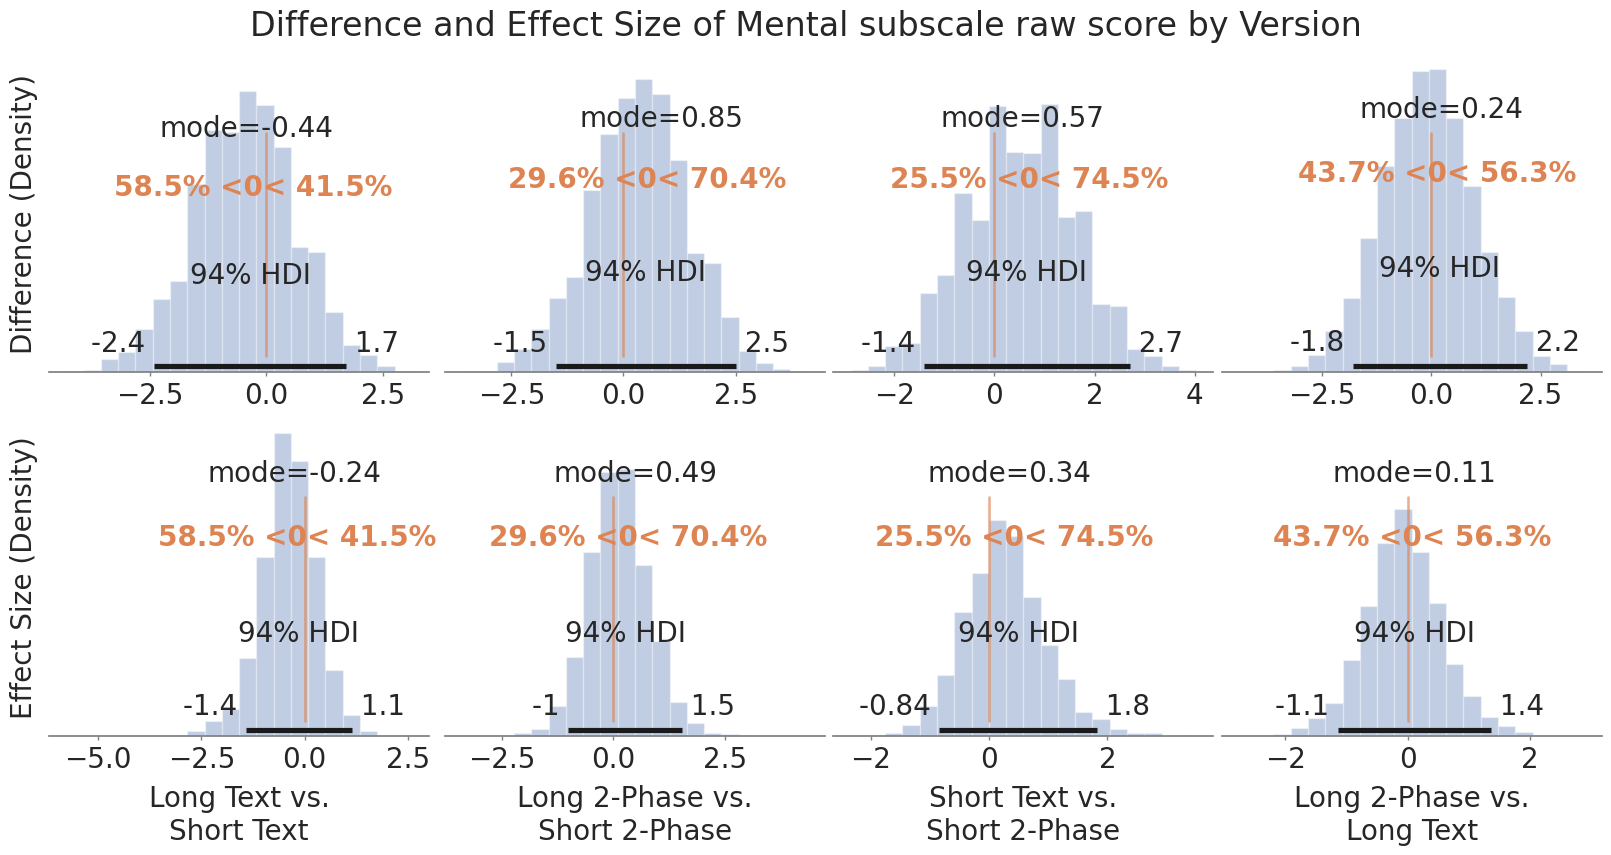


Processing subscale: Physical
Using Physical_obs and Physical_eta


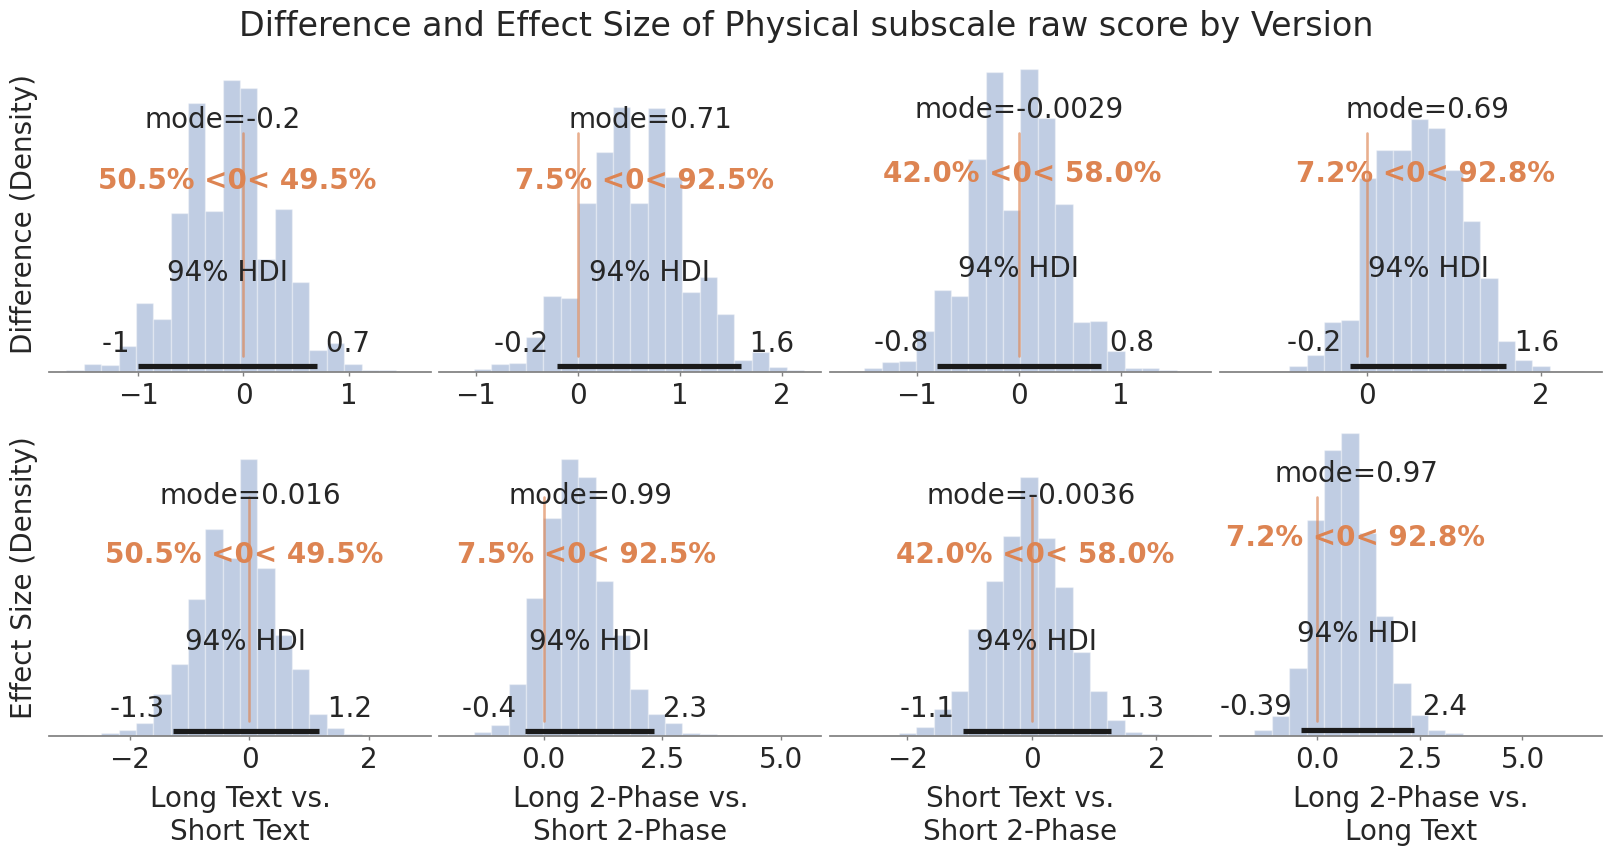


Processing subscale: Temporal
Using Temporal_obs and Temporal_eta


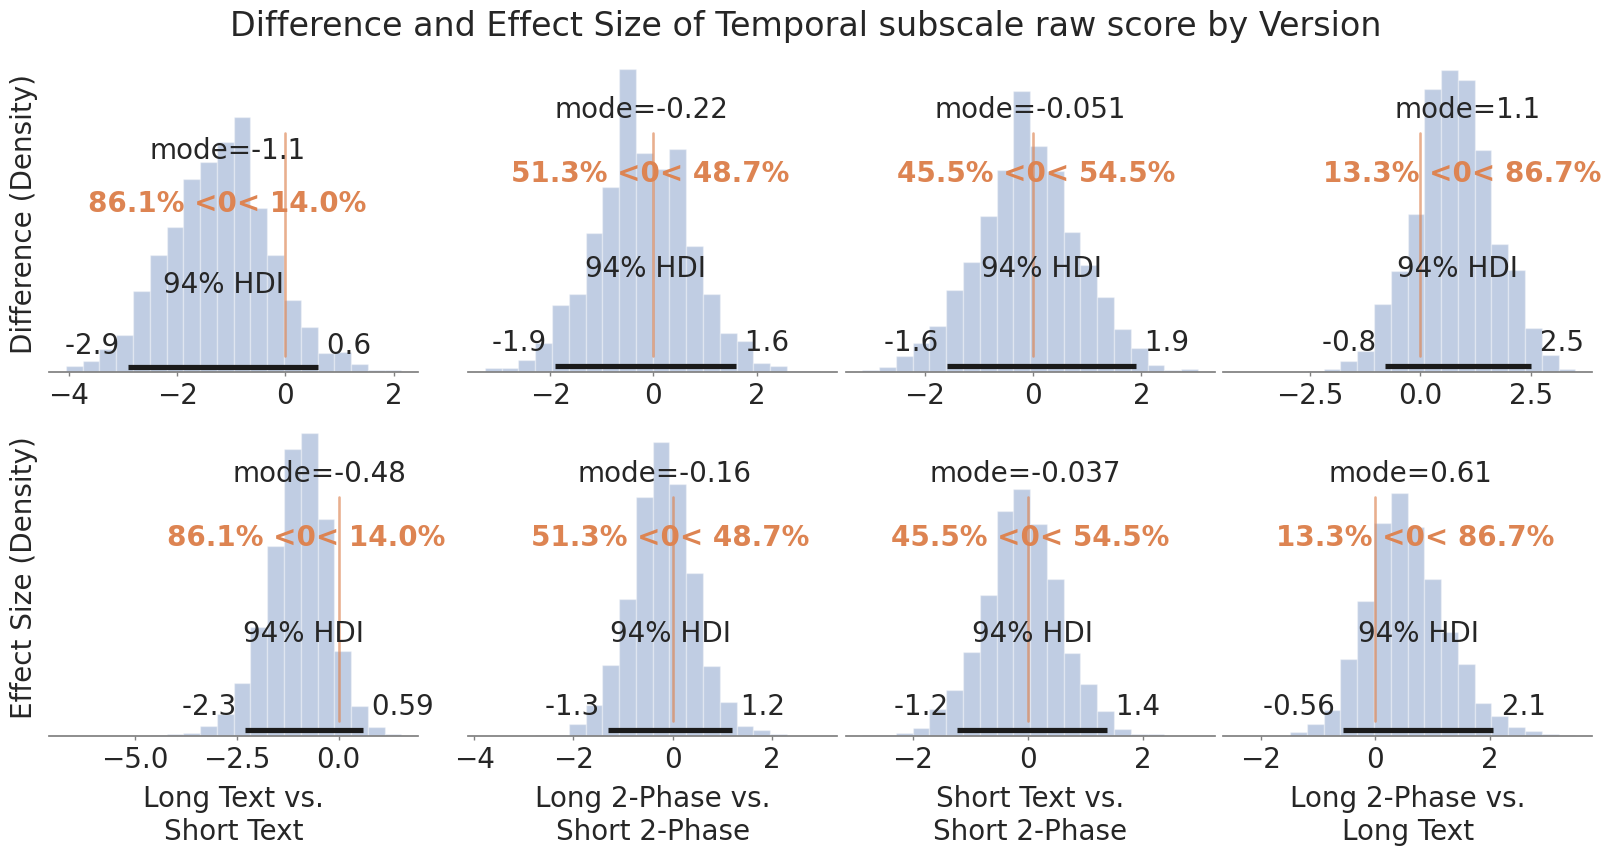


Processing subscale: Performance
Using Performance_obs and Performance_eta


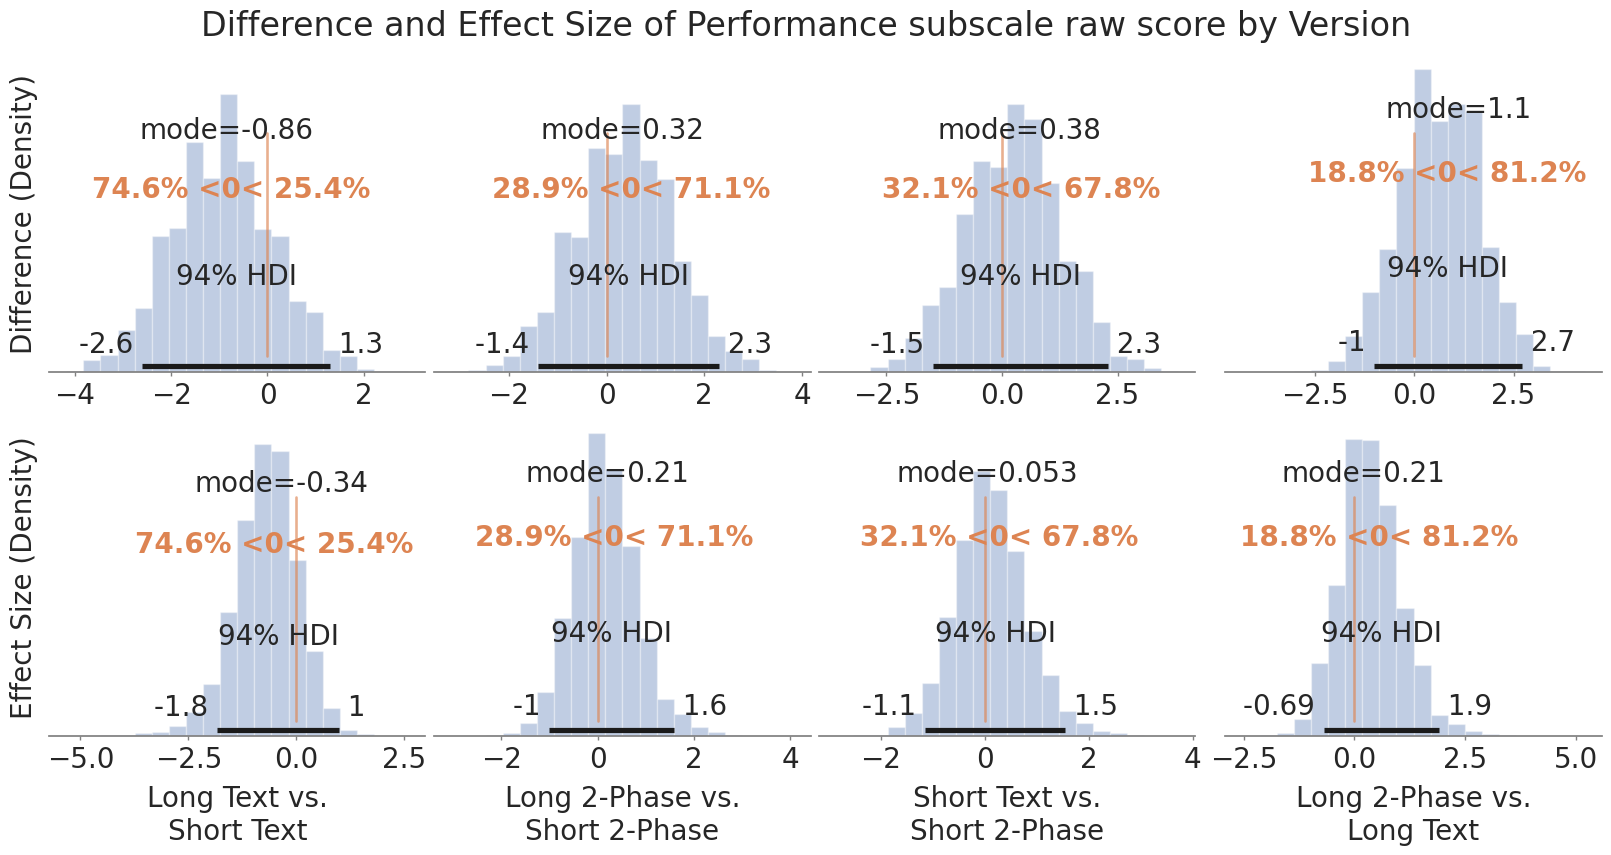


Processing subscale: Effort
Using Effort_obs and Effort_eta


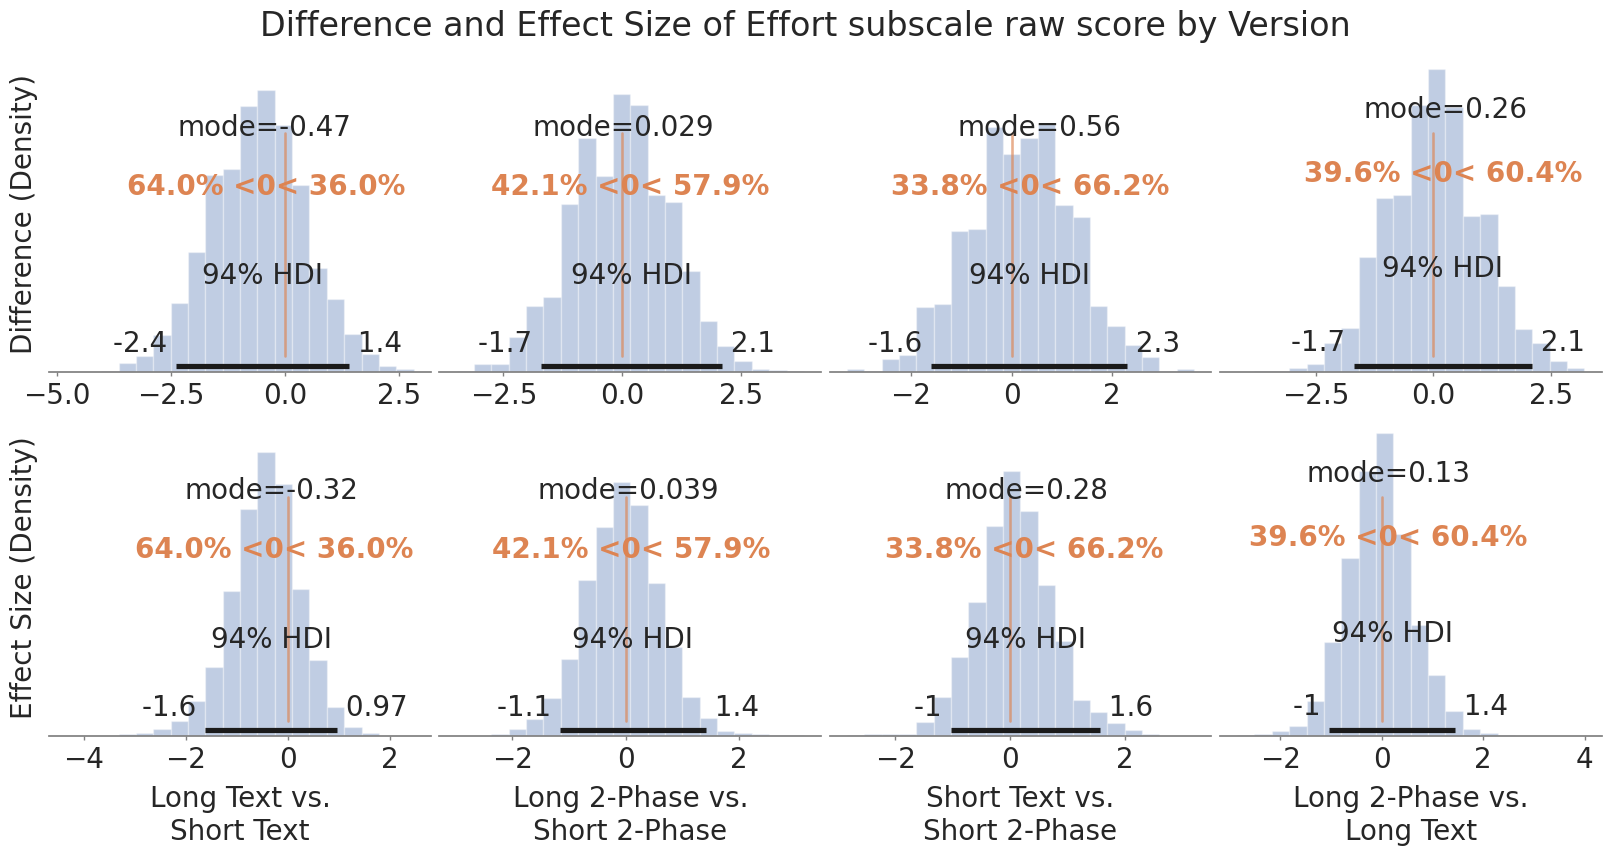


Processing subscale: Frustration
Using Frustration_obs and Frustration_eta


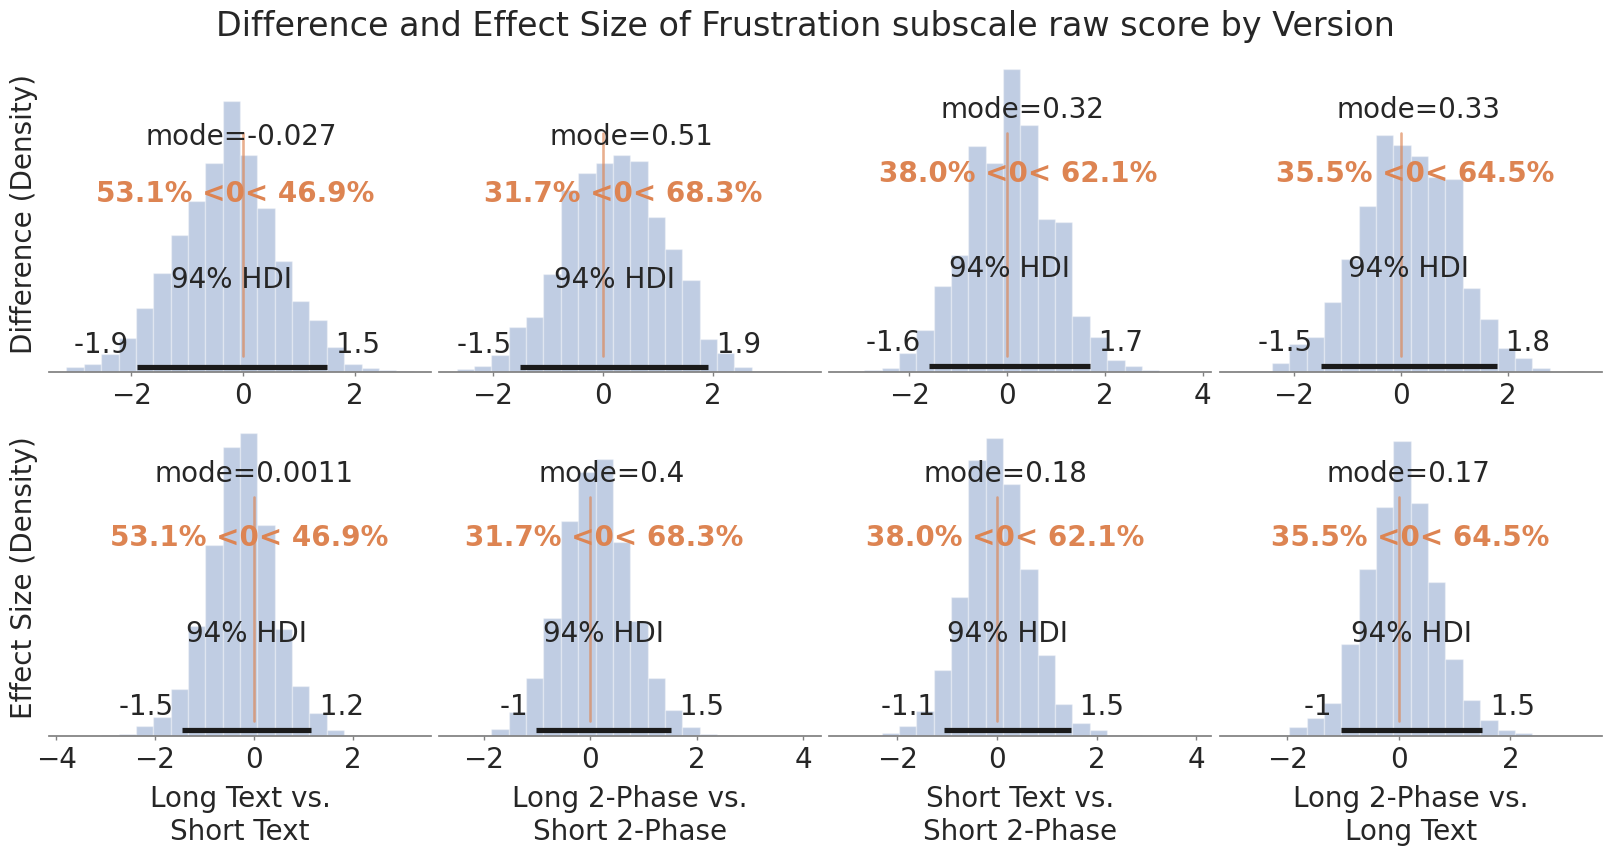

In [99]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
from numpyro.infer import Predictive

# Loop through each subscale in the results
for subscale in subscale_columns:
    print(f"\nProcessing subscale: {subscale}")
    print(f"Using {subscale}_obs and {subscale}_eta")

    # Prepare figure layout for the two rows
    n_cols = len(desired_order)  # Number of comparisons
    fig, axes = plt.subplots(
        2, n_cols, figsize=(16, 8), sharey='row', constrained_layout=True
    )

    # Define histogram bin size
    bin_size = 20

    # Create plots for the first row (difference plots)
    for i, label in enumerate(desired_order):
        az.plot_posterior(
            pairwise_differences_by_subscale[f"{subscale}_obs"],
            var_names=[label],
            ax=axes[0, i],
            hdi_prob=0.94,
            point_estimate="mode",
            ref_val=0,
            kind="hist",
            bins=bin_size,
            textsize=20,
        )
        
        axes[0, i].set_title("", fontsize=18)
        axes[0, i].grid(axis="x", linestyle="", alpha=0.6)  # X-axis grid lines only
        axes[0, i].grid(axis="y", linestyle="", alpha=0.0)    # No Y-axis grid lines

    # Create plots for the second row (effect size plots)
    for i, label in enumerate(desired_order):
        az.plot_posterior(
            pairwise_differences_by_subscale[f"{subscale}_cohensd_obs"],
            var_names=[label],
            ax=axes[1, i],
            hdi_prob=0.94,
            point_estimate="mode",
            ref_val=0,
            kind="hist",
            bins=bin_size,
            textsize=20,
        )
        axes[1, i].set_title("")
        axes[1, i].grid(axis="x", linestyle="", alpha=0.6)  # X-axis grid lines only
        axes[1, i].grid(axis="y", linestyle="", alpha=0.0)    # No Y-axis grid lines

    # Adjust labels and layout
    axes[0, 0].set_ylabel("Difference (Density)", fontsize=20)
    axes[1, 0].set_ylabel("Effect Size (Density)", fontsize=20)
    # set the x-axis label for the last row of plots with the version names
    for i in range(n_cols):
        axes[1, i].set_xlabel(name_mapping[desired_order[i]], fontsize=20)


    # set plt title
    plt.suptitle(f"Difference and Effect Size of {subscale} subscale raw score by Version", fontsize=24, y=1.05)

    # save the plot to
    plt.savefig(f"{path}/{subscale}_cog_diff.pdf", bbox_inches='tight')
    plt.show()



Processing subscale: Mental
Using Mental_obs


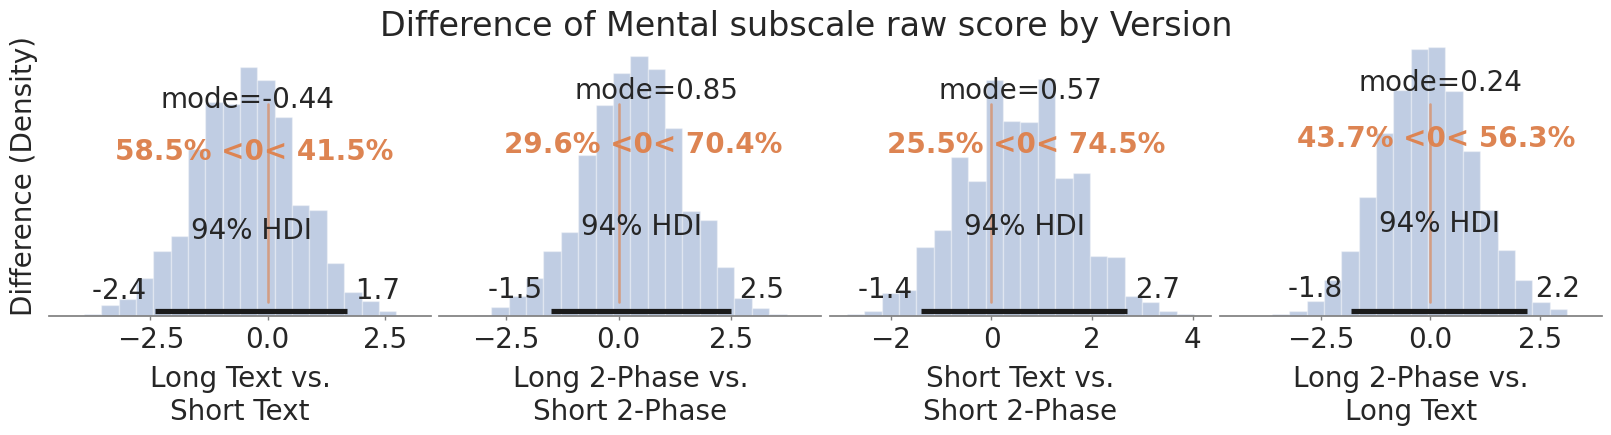


Processing subscale: Physical
Using Physical_obs


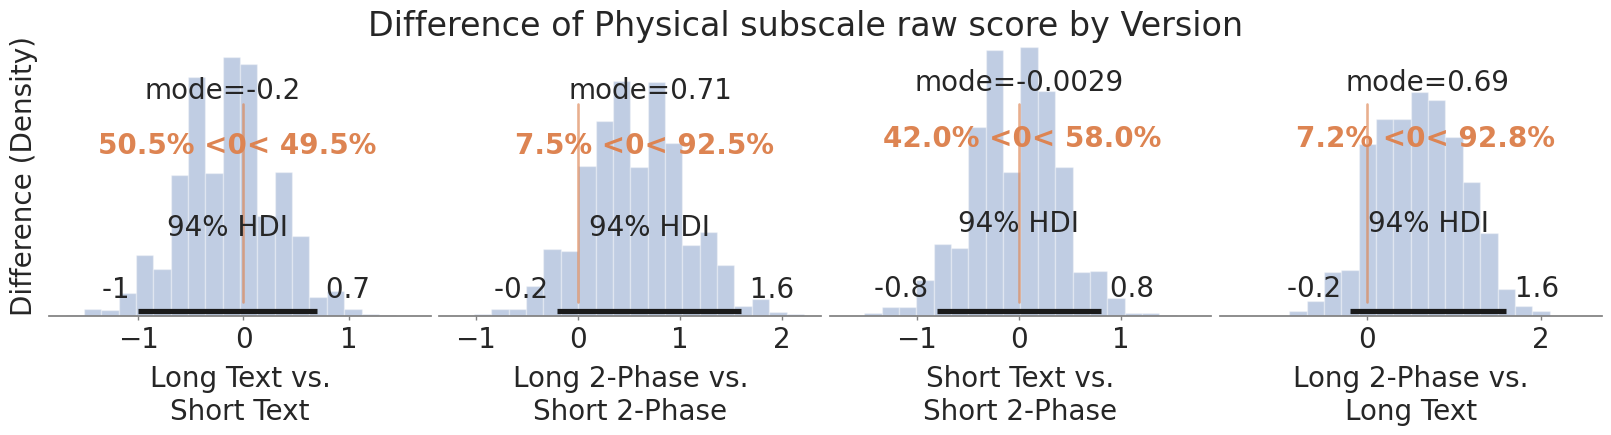


Processing subscale: Temporal
Using Temporal_obs


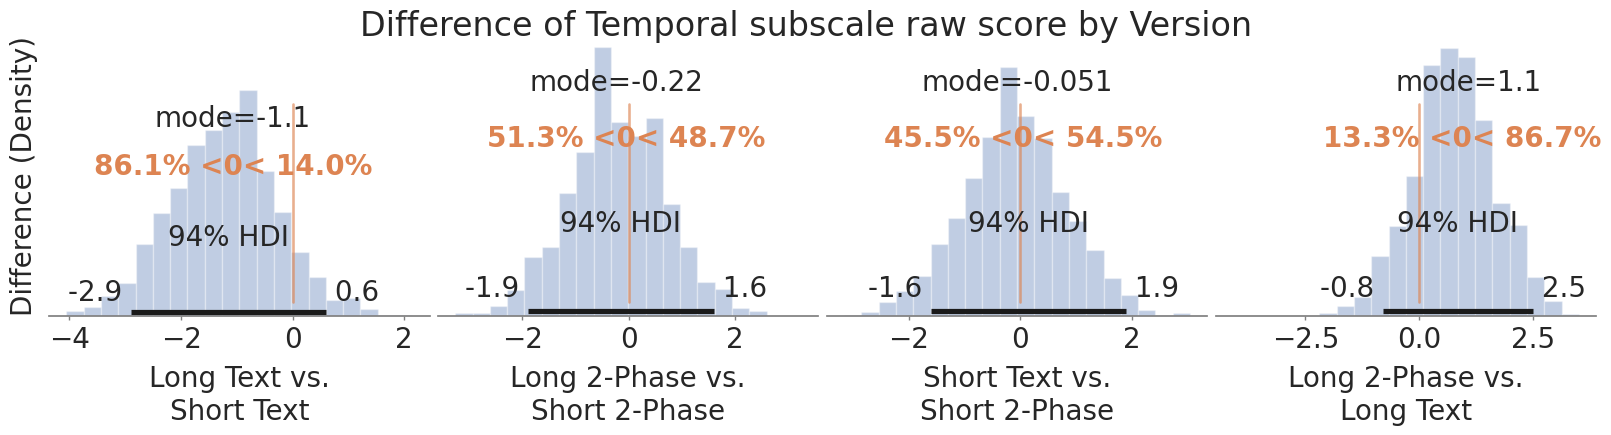


Processing subscale: Performance
Using Performance_obs


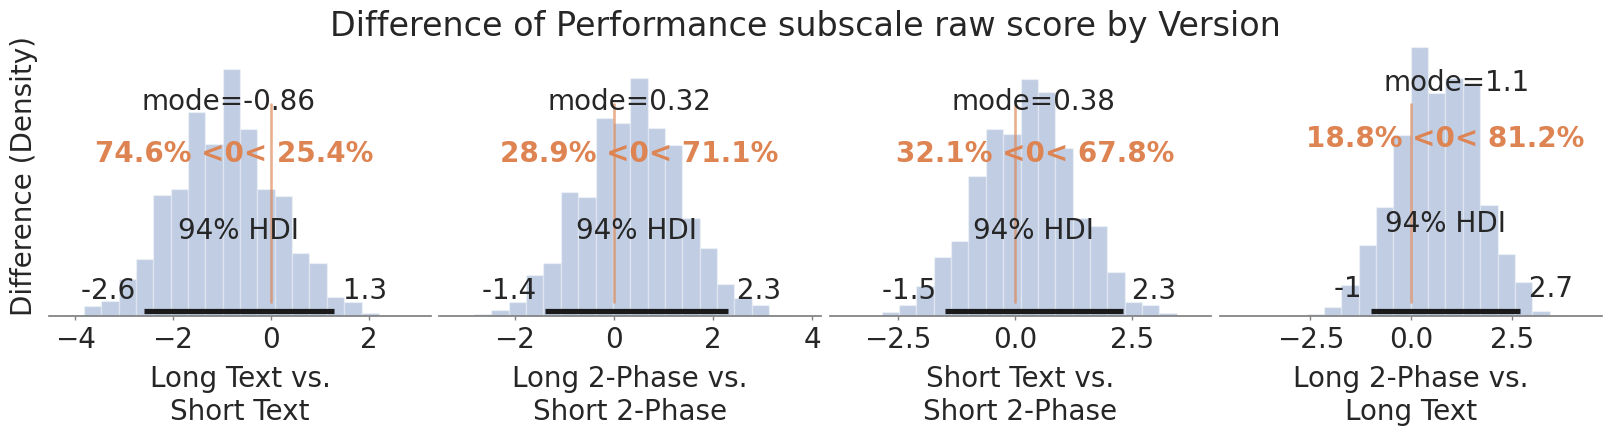


Processing subscale: Effort
Using Effort_obs


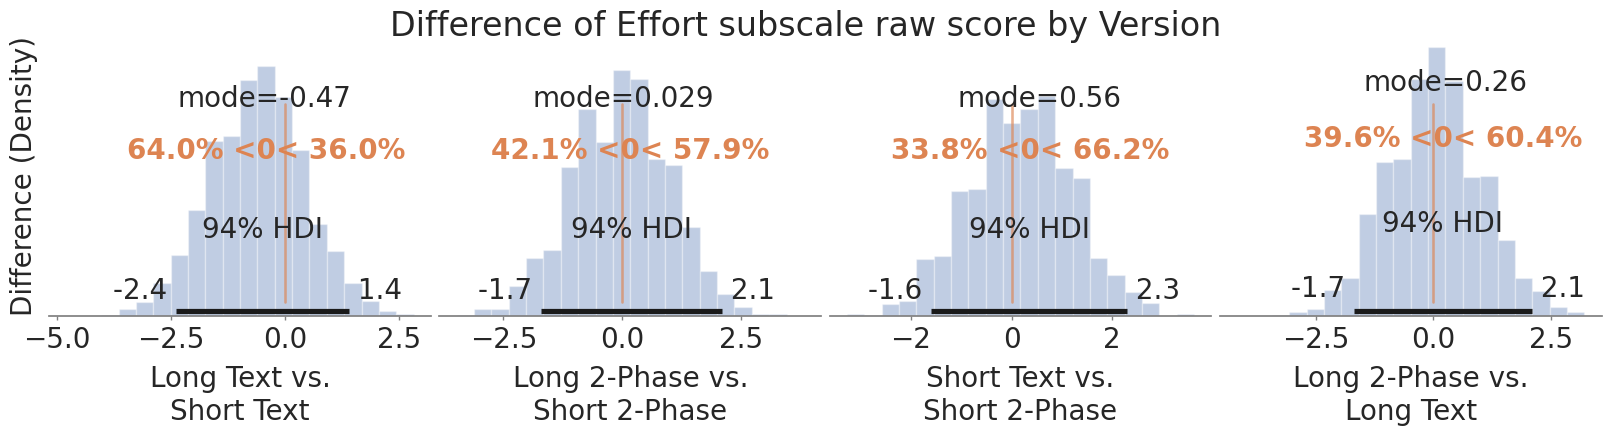


Processing subscale: Frustration
Using Frustration_obs


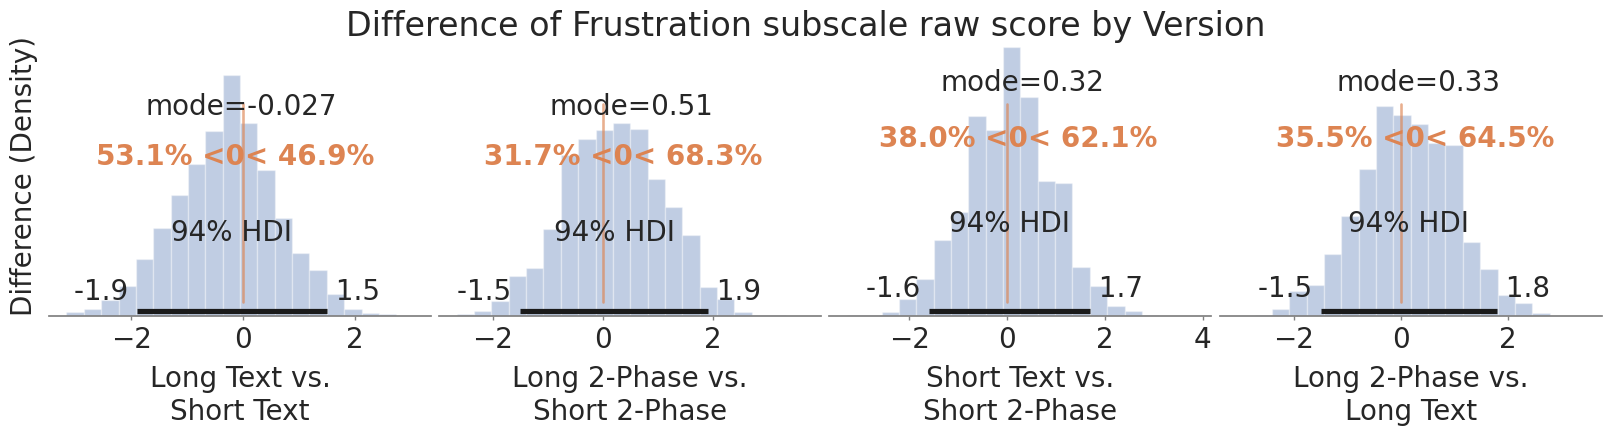

In [100]:
# Loop through each subscale in the results
for subscale in subscale_columns:
    print(f"\nProcessing subscale: {subscale}")
    print(f"Using {subscale}_obs")

    # Prepare figure layout for a single row
    n_cols = len(desired_order)  # Number of comparisons
    fig, axes = plt.subplots(
        1, n_cols, figsize=(n_cols * 4, 4), sharey=True, constrained_layout=True
    )

    # Define histogram bin size
    bin_size = 20

    # Create plots for the single row (difference plots)
    for i, label in enumerate(desired_order):
        az.plot_posterior(
            pairwise_differences_by_subscale[f"{subscale}_obs"],
            var_names=[label],
            ax=axes[i],
            hdi_prob=0.94,
            point_estimate="mode",
            ref_val=0,
            kind="hist",
            bins=bin_size,
            textsize=20,
        )
        axes[i].set_title("", fontsize=18)
        axes[i].grid(axis="x", linestyle="", alpha=0.6)  # X-axis grid lines only
        axes[i].grid(axis="y", linestyle="", alpha=0.0)  # No Y-axis grid lines

    # Adjust labels and layout
    axes[0].set_ylabel("Difference (Density)", fontsize=20)

    # Set x-axis labels with the version names
    for i in range(n_cols):
        axes[i].set_xlabel(name_mapping[desired_order[i]], fontsize=20)

    # Set overall plot title
    plt.suptitle(f"Difference of {subscale} subscale raw score by Version", fontsize=24, y=1.05)

    # Save the plot
    plt.savefig(f"{path}/{subscale}_cog_diff_single_row.pdf", bbox_inches='tight')

    # Show the plot
    plt.show()
